In [10]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import sys
import cv2
import matplotlib
import warnings
import seaborn as sns
import csv
import keras
from numpy import zeros
from matplotlib import pyplot as plt
from datetime import datetime
from subprocess import check_output
from keras.models import Sequential
from keras.utils import print_summary
from keras.layers import Dense, Conv2D, Conv3D, MaxPooling2D, MaxPooling3D, Dropout, Flatten, TimeDistributed, GRU, GlobalAveragePooling2D
from keras.preprocessing.image import image, ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import roc_curve, roc_auc_score
from keras.utils import print_summary
from keras.layers.recurrent import LSTM
from keras.applications import VGG19, VGG16
from keras.applications.imagenet_utils import preprocess_input
from keras.applications.resnet50 import ResNet50
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # showing and rendering figures
# io related
from skimage.io import imread
import os
from glob import glob
# not needed in Kaggle, but required in Jupyter
%matplotlib inline 
warnings.filterwarnings('ignore')
sns.set(style='dark')

In [54]:
NUM_CLASSES = 5
# we need images of same size so we convert them into the size
WIDTH = 256
HEIGHT = 256
DEPTH = 3
inputShape = (HEIGHT, WIDTH, DEPTH)
dsize = (HEIGHT, WIDTH)
# initialize number of epochs to train for, initial learning rate and batch size
EPOCHS = 6 
BATCH_SIZE = 30
INIT_LR = 1e-3
#global variables
ImageNameDataHash = {}
uniquePatientIDList = []

base_image_dir = r'/mnt/disks/user/project/Sample raw' #os.path.join('..', 'input', 'diabetic-retinopathy-detection')
CLAHE_path = r'/mnt/disks/user/project/Sample CLAHE'
gray_scale_path = r'/mnt/disks/user/project/Sample gray'
Only_CLAHE_path = r'/mnt/disks/user/project/Sample only_CLAHE'
HE_path = r'/mnt/disks/user/project/Sample HE'
cropped_image_path = r'/mnt/disks/user/project/Sample Cropped'
sample_img = '31_right.jpeg'

In [4]:
retina_df = pd.read_csv('trainLabels.csv')
retina_df.head()

,image,level
0,10_left,0
1,10_right,0
2,13_left,0
3,13_right,0
4,15_left,1


In [5]:
retina_df['PatientID'] = retina_df['image'].map(lambda x: x.split('_')[0])
retina_df['eye'] = retina_df['image'].map(lambda x: 1 if x.split('_')[-1]=='left' else 0)
retina_df['path'] = retina_df['image'].map(lambda x: os.path.join(base_image_dir,'{}.jpeg'.format(x)))
#retina_df = retina_df.head(5000)
print(retina_df.shape)
retina_df.head()

(35126, 5)


,image,level,PatientID,eye,path
0,10_left,0,10,1,/mnt/disks/user/project/Sample raw/10_left.jpeg
1,10_right,0,10,0,/mnt/disks/user/project/Sample raw/10_right.jpeg
2,13_left,0,13,1,/mnt/disks/user/project/Sample raw/13_left.jpeg
3,13_right,0,13,0,/mnt/disks/user/project/Sample raw/13_right.jpeg
4,15_left,1,15,1,/mnt/disks/user/project/Sample raw/15_left.jpeg


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc00515e0b8>,
      dtype=object)

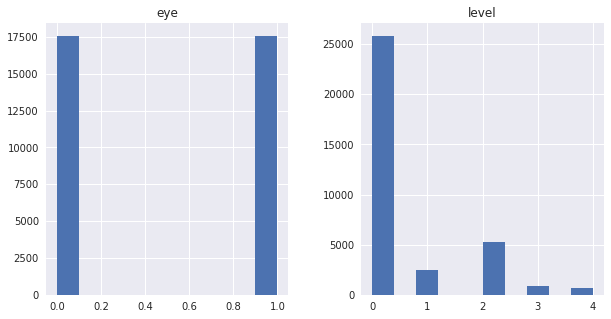

In [6]:
retina_df[['level', 'eye']].hist(figsize = (10, 5))

In [28]:
def crop_image_from_gray(img,tol=7):
    #Crop out black borders
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        mask = gray_img>tol        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0):
            return img
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def circle_crop_v2(img):
    #Create circular crop around image centre
    img = cv2.imread(img)
    img = crop_image_from_gray(img)
    height, width, depth = img.shape
    largest_side = np.max((height, width))
    img = cv2.resize(img, (largest_side, largest_side))
    height, width, depth = img.shape
    x = int(width / 2)
    y = int(height / 2)
    r = np.amin((x, y))
    circle_img = np.zeros((height, width), np.uint8)
    cv2.circle(circle_img, (x, y), int(r), 1, thickness=-1)
    img = cv2.bitwise_and(img, img, mask=circle_img)
    img = crop_image_from_gray(img)
    return img

def clahe_rgb(img_path,clip_limit, tile_size):
    bgr = cv2.imread(img_path)
    lab = cv2.cvtColor(bgr, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=(tile_size,tile_size))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr

def CLAHE(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    lab_planes = cv2.split(lab)
    #clahe = cv2.createCLAHE(clipLimit=2.0,tileGridSize=(gridsize,gridsize))
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    lab_planes[0] = clahe.apply(lab_planes[0])
    lab = cv2.merge(lab_planes)
    bgr = cv2.cvtColor(lab, cv2.COLOR_LAB2BGR)
    return bgr

def histogram_equalize(img):
    b, g, r = cv2.split(img)
    red = cv2.equalizeHist(r)
    green = cv2.equalizeHist(g)
    blue = cv2.equalizeHist(b)
    return cv2.merge((blue, green, red))

def convert_to_grayscale(img):
    img = cv2.imread(img)
    bgr = cv2.cvtColor(img, cv2.cv2.COLOR_BGR2GRAY)
    return bgr

# Image Resize

(-0.5, 666.5, 669.5, -0.5)

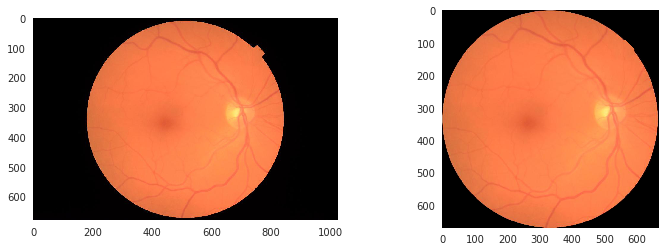

In [30]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
spaceboy = cv2.imread(base_image_dir + '/' + sample_img )
ax[0].imshow(cv2.cvtColor(spaceboy, cv2.COLOR_BGR2RGB))
ax[0].axis('on')

cropboy = circle_crop_v2(base_image_dir + '/' + sample_img)
ax[1].imshow(cv2.cvtColor(cropboy, cv2.COLOR_BGR2RGB))
ax[1].axis('on')

In [31]:
#Resize and crop all the images based on the edges
index = 0
print(dsize)
for file in os.listdir(base_image_dir):
    index = index + 1
    img_full_path = os.path.join(base_image_dir, file)
    cropped_img  = circle_crop_v2(img_full_path)
    #cv2.cvtColor(cropped_img, cv2.COLOR_BGR2RGB)
    # resize image
    cropped_img = cv2.resize(cropped_img, dsize)
    cv2.imwrite(cropped_image_path + '/' + file, cropped_img) 
    arr = img_to_array(cropped_img)
    print(index , ' : ', cropped_image_path + '/' + file) # + ' : ==> ' + arr.shape)

(256, 256)
1  :  /mnt/disks/user/project/Sample Cropped/1955_right.jpeg
2  :  /mnt/disks/user/project/Sample Cropped/4514_right.jpeg
3  :  /mnt/disks/user/project/Sample Cropped/5285_right.jpeg
4  :  /mnt/disks/user/project/Sample Cropped/3434_left.jpeg
5  :  /mnt/disks/user/project/Sample Cropped/1667_left.jpeg
6  :  /mnt/disks/user/project/Sample Cropped/412_right.jpeg
7  :  /mnt/disks/user/project/Sample Cropped/803_left.jpeg
8  :  /mnt/disks/user/project/Sample Cropped/2605_left.jpeg
9  :  /mnt/disks/user/project/Sample Cropped/20_left.jpeg
10  :  /mnt/disks/user/project/Sample Cropped/33_left.jpeg
11  :  /mnt/disks/user/project/Sample Cropped/320_left.jpeg
12  :  /mnt/disks/user/project/Sample Cropped/1469_right.jpeg
13  :  /mnt/disks/user/project/Sample Cropped/4802_left.jpeg
14  :  /mnt/disks/user/project/Sample Cropped/5146_right.jpeg
15  :  /mnt/disks/user/project/Sample Cropped/1017_left.jpeg
16  :  /mnt/disks/user/project/Sample Cropped/4800_left.jpeg
17  :  /mnt/disks/user/

139  :  /mnt/disks/user/project/Sample Cropped/2353_left.jpeg
140  :  /mnt/disks/user/project/Sample Cropped/4731_left.jpeg
141  :  /mnt/disks/user/project/Sample Cropped/3700_right.jpeg
142  :  /mnt/disks/user/project/Sample Cropped/4190_left.jpeg
143  :  /mnt/disks/user/project/Sample Cropped/2087_left.jpeg
144  :  /mnt/disks/user/project/Sample Cropped/4827_left.jpeg
145  :  /mnt/disks/user/project/Sample Cropped/2865_left.jpeg
146  :  /mnt/disks/user/project/Sample Cropped/203_left.jpeg
147  :  /mnt/disks/user/project/Sample Cropped/1710_right.jpeg
148  :  /mnt/disks/user/project/Sample Cropped/2606_right.jpeg
149  :  /mnt/disks/user/project/Sample Cropped/1096_right.jpeg
150  :  /mnt/disks/user/project/Sample Cropped/3393_left.jpeg
151  :  /mnt/disks/user/project/Sample Cropped/1361_left.jpeg
152  :  /mnt/disks/user/project/Sample Cropped/2338_left.jpeg
153  :  /mnt/disks/user/project/Sample Cropped/3023_left.jpeg
154  :  /mnt/disks/user/project/Sample Cropped/4518_left.jpeg
155  

276  :  /mnt/disks/user/project/Sample Cropped/3519_left.jpeg
277  :  /mnt/disks/user/project/Sample Cropped/5082_right.jpeg
278  :  /mnt/disks/user/project/Sample Cropped/456_left.jpeg
279  :  /mnt/disks/user/project/Sample Cropped/5448_left.jpeg
280  :  /mnt/disks/user/project/Sample Cropped/2046_right.jpeg
281  :  /mnt/disks/user/project/Sample Cropped/5240_right.jpeg
282  :  /mnt/disks/user/project/Sample Cropped/1887_left.jpeg
283  :  /mnt/disks/user/project/Sample Cropped/1020_left.jpeg
284  :  /mnt/disks/user/project/Sample Cropped/6075_left.jpeg
285  :  /mnt/disks/user/project/Sample Cropped/5033_left.jpeg
286  :  /mnt/disks/user/project/Sample Cropped/2969_left.jpeg
287  :  /mnt/disks/user/project/Sample Cropped/5456_left.jpeg
288  :  /mnt/disks/user/project/Sample Cropped/4419_right.jpeg
289  :  /mnt/disks/user/project/Sample Cropped/4804_left.jpeg
290  :  /mnt/disks/user/project/Sample Cropped/690_right.jpeg
291  :  /mnt/disks/user/project/Sample Cropped/622_left.jpeg
292  :

412  :  /mnt/disks/user/project/Sample Cropped/2754_right.jpeg
413  :  /mnt/disks/user/project/Sample Cropped/2129_left.jpeg
414  :  /mnt/disks/user/project/Sample Cropped/4558_left.jpeg
415  :  /mnt/disks/user/project/Sample Cropped/1508_right.jpeg
416  :  /mnt/disks/user/project/Sample Cropped/3661_left.jpeg
417  :  /mnt/disks/user/project/Sample Cropped/502_right.jpeg
418  :  /mnt/disks/user/project/Sample Cropped/3059_left.jpeg
419  :  /mnt/disks/user/project/Sample Cropped/5521_right.jpeg
420  :  /mnt/disks/user/project/Sample Cropped/301_right.jpeg
421  :  /mnt/disks/user/project/Sample Cropped/1574_right.jpeg
422  :  /mnt/disks/user/project/Sample Cropped/5618_left.jpeg
423  :  /mnt/disks/user/project/Sample Cropped/3688_left.jpeg
424  :  /mnt/disks/user/project/Sample Cropped/5200_left.jpeg
425  :  /mnt/disks/user/project/Sample Cropped/509_right.jpeg
426  :  /mnt/disks/user/project/Sample Cropped/3348_left.jpeg
427  :  /mnt/disks/user/project/Sample Cropped/3698_left.jpeg
428 

546  :  /mnt/disks/user/project/Sample Cropped/3823_left.jpeg
547  :  /mnt/disks/user/project/Sample Cropped/2488_left.jpeg
548  :  /mnt/disks/user/project/Sample Cropped/3159_left.jpeg
549  :  /mnt/disks/user/project/Sample Cropped/3444_right.jpeg
550  :  /mnt/disks/user/project/Sample Cropped/2978_left.jpeg
551  :  /mnt/disks/user/project/Sample Cropped/1318_left.jpeg
552  :  /mnt/disks/user/project/Sample Cropped/1929_left.jpeg
553  :  /mnt/disks/user/project/Sample Cropped/3851_left.jpeg
554  :  /mnt/disks/user/project/Sample Cropped/5713_left.jpeg
555  :  /mnt/disks/user/project/Sample Cropped/6053_left.jpeg
556  :  /mnt/disks/user/project/Sample Cropped/2354_right.jpeg
557  :  /mnt/disks/user/project/Sample Cropped/800_left.jpeg
558  :  /mnt/disks/user/project/Sample Cropped/2071_right.jpeg
559  :  /mnt/disks/user/project/Sample Cropped/4470_left.jpeg
560  :  /mnt/disks/user/project/Sample Cropped/1092_left.jpeg
561  :  /mnt/disks/user/project/Sample Cropped/2953_right.jpeg
562  

679  :  /mnt/disks/user/project/Sample Cropped/1501_right.jpeg
680  :  /mnt/disks/user/project/Sample Cropped/4184_left.jpeg
681  :  /mnt/disks/user/project/Sample Cropped/5155_left.jpeg
682  :  /mnt/disks/user/project/Sample Cropped/4567_left.jpeg
683  :  /mnt/disks/user/project/Sample Cropped/5201_left.jpeg
684  :  /mnt/disks/user/project/Sample Cropped/322_left.jpeg
685  :  /mnt/disks/user/project/Sample Cropped/4769_left.jpeg
686  :  /mnt/disks/user/project/Sample Cropped/2465_right.jpeg
687  :  /mnt/disks/user/project/Sample Cropped/2062_left.jpeg
688  :  /mnt/disks/user/project/Sample Cropped/2205_left.jpeg
689  :  /mnt/disks/user/project/Sample Cropped/862_left.jpeg
690  :  /mnt/disks/user/project/Sample Cropped/5558_right.jpeg
691  :  /mnt/disks/user/project/Sample Cropped/5710_right.jpeg
692  :  /mnt/disks/user/project/Sample Cropped/195_left.jpeg
693  :  /mnt/disks/user/project/Sample Cropped/5936_left.jpeg
694  :  /mnt/disks/user/project/Sample Cropped/1412_left.jpeg
695  : 

813  :  /mnt/disks/user/project/Sample Cropped/2029_right.jpeg
814  :  /mnt/disks/user/project/Sample Cropped/4830_right.jpeg
815  :  /mnt/disks/user/project/Sample Cropped/2258_right.jpeg
816  :  /mnt/disks/user/project/Sample Cropped/4914_left.jpeg
817  :  /mnt/disks/user/project/Sample Cropped/6168_left.jpeg
818  :  /mnt/disks/user/project/Sample Cropped/968_right.jpeg
819  :  /mnt/disks/user/project/Sample Cropped/6291_left.jpeg
820  :  /mnt/disks/user/project/Sample Cropped/4002_right.jpeg
821  :  /mnt/disks/user/project/Sample Cropped/3072_left.jpeg
822  :  /mnt/disks/user/project/Sample Cropped/5344_right.jpeg
823  :  /mnt/disks/user/project/Sample Cropped/842_left.jpeg
824  :  /mnt/disks/user/project/Sample Cropped/2813_left.jpeg
825  :  /mnt/disks/user/project/Sample Cropped/1914_left.jpeg
826  :  /mnt/disks/user/project/Sample Cropped/6089_left.jpeg
827  :  /mnt/disks/user/project/Sample Cropped/5508_left.jpeg
828  :  /mnt/disks/user/project/Sample Cropped/5589_right.jpeg
829

949  :  /mnt/disks/user/project/Sample Cropped/140_right.jpeg
950  :  /mnt/disks/user/project/Sample Cropped/3416_right.jpeg
951  :  /mnt/disks/user/project/Sample Cropped/4304_right.jpeg
952  :  /mnt/disks/user/project/Sample Cropped/2451_left.jpeg
953  :  /mnt/disks/user/project/Sample Cropped/3000_left.jpeg
954  :  /mnt/disks/user/project/Sample Cropped/5655_right.jpeg
955  :  /mnt/disks/user/project/Sample Cropped/599_right.jpeg
956  :  /mnt/disks/user/project/Sample Cropped/2869_right.jpeg
957  :  /mnt/disks/user/project/Sample Cropped/3319_right.jpeg
958  :  /mnt/disks/user/project/Sample Cropped/4135_right.jpeg
959  :  /mnt/disks/user/project/Sample Cropped/3580_right.jpeg
960  :  /mnt/disks/user/project/Sample Cropped/1424_left.jpeg
961  :  /mnt/disks/user/project/Sample Cropped/70_right.jpeg
962  :  /mnt/disks/user/project/Sample Cropped/3743_right.jpeg
963  :  /mnt/disks/user/project/Sample Cropped/800_right.jpeg
964  :  /mnt/disks/user/project/Sample Cropped/4805_left.jpeg
9

1082  :  /mnt/disks/user/project/Sample Cropped/2218_left.jpeg
1083  :  /mnt/disks/user/project/Sample Cropped/4548_right.jpeg
1084  :  /mnt/disks/user/project/Sample Cropped/5368_right.jpeg
1085  :  /mnt/disks/user/project/Sample Cropped/3112_right.jpeg
1086  :  /mnt/disks/user/project/Sample Cropped/5308_left.jpeg
1087  :  /mnt/disks/user/project/Sample Cropped/5185_left.jpeg
1088  :  /mnt/disks/user/project/Sample Cropped/1259_right.jpeg
1089  :  /mnt/disks/user/project/Sample Cropped/3376_left.jpeg
1090  :  /mnt/disks/user/project/Sample Cropped/3553_right.jpeg
1091  :  /mnt/disks/user/project/Sample Cropped/3894_right.jpeg
1092  :  /mnt/disks/user/project/Sample Cropped/2071_left.jpeg
1093  :  /mnt/disks/user/project/Sample Cropped/5332_right.jpeg
1094  :  /mnt/disks/user/project/Sample Cropped/5841_right.jpeg
1095  :  /mnt/disks/user/project/Sample Cropped/1002_right.jpeg
1096  :  /mnt/disks/user/project/Sample Cropped/3298_right.jpeg
1097  :  /mnt/disks/user/project/Sample Cropp

1215  :  /mnt/disks/user/project/Sample Cropped/5083_right.jpeg
1216  :  /mnt/disks/user/project/Sample Cropped/3141_right.jpeg
1217  :  /mnt/disks/user/project/Sample Cropped/3146_left.jpeg
1218  :  /mnt/disks/user/project/Sample Cropped/2222_left.jpeg
1219  :  /mnt/disks/user/project/Sample Cropped/5659_left.jpeg
1220  :  /mnt/disks/user/project/Sample Cropped/511_right.jpeg
1221  :  /mnt/disks/user/project/Sample Cropped/375_left.jpeg
1222  :  /mnt/disks/user/project/Sample Cropped/229_right.jpeg
1223  :  /mnt/disks/user/project/Sample Cropped/3327_right.jpeg
1224  :  /mnt/disks/user/project/Sample Cropped/3992_right.jpeg
1225  :  /mnt/disks/user/project/Sample Cropped/5346_right.jpeg
1226  :  /mnt/disks/user/project/Sample Cropped/1333_right.jpeg
1227  :  /mnt/disks/user/project/Sample Cropped/3307_right.jpeg
1228  :  /mnt/disks/user/project/Sample Cropped/5934_right.jpeg
1229  :  /mnt/disks/user/project/Sample Cropped/5646_right.jpeg
1230  :  /mnt/disks/user/project/Sample Cropped

1346  :  /mnt/disks/user/project/Sample Cropped/3634_left.jpeg
1347  :  /mnt/disks/user/project/Sample Cropped/3446_right.jpeg
1348  :  /mnt/disks/user/project/Sample Cropped/4695_left.jpeg
1349  :  /mnt/disks/user/project/Sample Cropped/851_left.jpeg
1350  :  /mnt/disks/user/project/Sample Cropped/4125_left.jpeg
1351  :  /mnt/disks/user/project/Sample Cropped/5045_left.jpeg
1352  :  /mnt/disks/user/project/Sample Cropped/3748_right.jpeg
1353  :  /mnt/disks/user/project/Sample Cropped/3194_left.jpeg
1354  :  /mnt/disks/user/project/Sample Cropped/279_right.jpeg
1355  :  /mnt/disks/user/project/Sample Cropped/4741_left.jpeg
1356  :  /mnt/disks/user/project/Sample Cropped/256_left.jpeg
1357  :  /mnt/disks/user/project/Sample Cropped/1706_right.jpeg
1358  :  /mnt/disks/user/project/Sample Cropped/4534_left.jpeg
1359  :  /mnt/disks/user/project/Sample Cropped/4090_right.jpeg
1360  :  /mnt/disks/user/project/Sample Cropped/1639_right.jpeg
1361  :  /mnt/disks/user/project/Sample Cropped/190_

1479  :  /mnt/disks/user/project/Sample Cropped/5573_left.jpeg
1480  :  /mnt/disks/user/project/Sample Cropped/1058_right.jpeg
1481  :  /mnt/disks/user/project/Sample Cropped/4266_left.jpeg
1482  :  /mnt/disks/user/project/Sample Cropped/3473_right.jpeg
1483  :  /mnt/disks/user/project/Sample Cropped/1431_right.jpeg
1484  :  /mnt/disks/user/project/Sample Cropped/3501_left.jpeg
1485  :  /mnt/disks/user/project/Sample Cropped/5171_left.jpeg
1486  :  /mnt/disks/user/project/Sample Cropped/2905_left.jpeg
1487  :  /mnt/disks/user/project/Sample Cropped/3372_left.jpeg
1488  :  /mnt/disks/user/project/Sample Cropped/2818_right.jpeg
1489  :  /mnt/disks/user/project/Sample Cropped/2495_left.jpeg
1490  :  /mnt/disks/user/project/Sample Cropped/2697_left.jpeg
1491  :  /mnt/disks/user/project/Sample Cropped/1277_left.jpeg
1492  :  /mnt/disks/user/project/Sample Cropped/1316_left.jpeg
1493  :  /mnt/disks/user/project/Sample Cropped/2562_right.jpeg
1494  :  /mnt/disks/user/project/Sample Cropped/74

1612  :  /mnt/disks/user/project/Sample Cropped/6263_left.jpeg
1613  :  /mnt/disks/user/project/Sample Cropped/825_left.jpeg
1614  :  /mnt/disks/user/project/Sample Cropped/3614_left.jpeg
1615  :  /mnt/disks/user/project/Sample Cropped/2252_left.jpeg
1616  :  /mnt/disks/user/project/Sample Cropped/5622_right.jpeg
1617  :  /mnt/disks/user/project/Sample Cropped/2829_right.jpeg
1618  :  /mnt/disks/user/project/Sample Cropped/1267_left.jpeg
1619  :  /mnt/disks/user/project/Sample Cropped/1394_left.jpeg
1620  :  /mnt/disks/user/project/Sample Cropped/5298_left.jpeg
1621  :  /mnt/disks/user/project/Sample Cropped/1589_right.jpeg
1622  :  /mnt/disks/user/project/Sample Cropped/5492_left.jpeg
1623  :  /mnt/disks/user/project/Sample Cropped/4058_right.jpeg
1624  :  /mnt/disks/user/project/Sample Cropped/4739_right.jpeg
1625  :  /mnt/disks/user/project/Sample Cropped/4395_right.jpeg
1626  :  /mnt/disks/user/project/Sample Cropped/4186_right.jpeg
1627  :  /mnt/disks/user/project/Sample Cropped/1

1742  :  /mnt/disks/user/project/Sample Cropped/2999_left.jpeg
1743  :  /mnt/disks/user/project/Sample Cropped/3727_left.jpeg
1744  :  /mnt/disks/user/project/Sample Cropped/2768_left.jpeg
1745  :  /mnt/disks/user/project/Sample Cropped/3060_left.jpeg
1746  :  /mnt/disks/user/project/Sample Cropped/5559_left.jpeg
1747  :  /mnt/disks/user/project/Sample Cropped/698_right.jpeg
1748  :  /mnt/disks/user/project/Sample Cropped/6205_right.jpeg
1749  :  /mnt/disks/user/project/Sample Cropped/3655_right.jpeg
1750  :  /mnt/disks/user/project/Sample Cropped/2952_right.jpeg
1751  :  /mnt/disks/user/project/Sample Cropped/4351_left.jpeg
1752  :  /mnt/disks/user/project/Sample Cropped/2744_right.jpeg
1753  :  /mnt/disks/user/project/Sample Cropped/4695_right.jpeg
1754  :  /mnt/disks/user/project/Sample Cropped/2804_right.jpeg
1755  :  /mnt/disks/user/project/Sample Cropped/3824_left.jpeg
1756  :  /mnt/disks/user/project/Sample Cropped/1034_right.jpeg
1757  :  /mnt/disks/user/project/Sample Cropped/

1874  :  /mnt/disks/user/project/Sample Cropped/1926_right.jpeg
1875  :  /mnt/disks/user/project/Sample Cropped/3641_left.jpeg
1876  :  /mnt/disks/user/project/Sample Cropped/643_right.jpeg
1877  :  /mnt/disks/user/project/Sample Cropped/22_left.jpeg
1878  :  /mnt/disks/user/project/Sample Cropped/4829_left.jpeg
1879  :  /mnt/disks/user/project/Sample Cropped/4506_right.jpeg
1880  :  /mnt/disks/user/project/Sample Cropped/4710_right.jpeg
1881  :  /mnt/disks/user/project/Sample Cropped/6287_left.jpeg
1882  :  /mnt/disks/user/project/Sample Cropped/4954_right.jpeg
1883  :  /mnt/disks/user/project/Sample Cropped/5938_left.jpeg
1884  :  /mnt/disks/user/project/Sample Cropped/163_right.jpeg
1885  :  /mnt/disks/user/project/Sample Cropped/3846_right.jpeg
1886  :  /mnt/disks/user/project/Sample Cropped/4851_right.jpeg
1887  :  /mnt/disks/user/project/Sample Cropped/4838_left.jpeg
1888  :  /mnt/disks/user/project/Sample Cropped/1363_right.jpeg
1889  :  /mnt/disks/user/project/Sample Cropped/30

2006  :  /mnt/disks/user/project/Sample Cropped/4302_right.jpeg
2007  :  /mnt/disks/user/project/Sample Cropped/3400_left.jpeg
2008  :  /mnt/disks/user/project/Sample Cropped/72_right.jpeg
2009  :  /mnt/disks/user/project/Sample Cropped/3422_left.jpeg
2010  :  /mnt/disks/user/project/Sample Cropped/2079_right.jpeg
2011  :  /mnt/disks/user/project/Sample Cropped/899_left.jpeg
2012  :  /mnt/disks/user/project/Sample Cropped/1084_left.jpeg
2013  :  /mnt/disks/user/project/Sample Cropped/2660_right.jpeg
2014  :  /mnt/disks/user/project/Sample Cropped/1967_right.jpeg
2015  :  /mnt/disks/user/project/Sample Cropped/4545_left.jpeg
2016  :  /mnt/disks/user/project/Sample Cropped/686_left.jpeg
2017  :  /mnt/disks/user/project/Sample Cropped/4200_left.jpeg
2018  :  /mnt/disks/user/project/Sample Cropped/2528_right.jpeg
2019  :  /mnt/disks/user/project/Sample Cropped/4398_left.jpeg
2020  :  /mnt/disks/user/project/Sample Cropped/3080_left.jpeg
2021  :  /mnt/disks/user/project/Sample Cropped/234_l

2136  :  /mnt/disks/user/project/Sample Cropped/4939_left.jpeg
2137  :  /mnt/disks/user/project/Sample Cropped/2185_left.jpeg
2138  :  /mnt/disks/user/project/Sample Cropped/1610_right.jpeg
2139  :  /mnt/disks/user/project/Sample Cropped/5952_left.jpeg
2140  :  /mnt/disks/user/project/Sample Cropped/4080_right.jpeg
2141  :  /mnt/disks/user/project/Sample Cropped/602_right.jpeg
2142  :  /mnt/disks/user/project/Sample Cropped/5811_right.jpeg
2143  :  /mnt/disks/user/project/Sample Cropped/6049_left.jpeg
2144  :  /mnt/disks/user/project/Sample Cropped/224_right.jpeg
2145  :  /mnt/disks/user/project/Sample Cropped/987_left.jpeg
2146  :  /mnt/disks/user/project/Sample Cropped/5042_left.jpeg
2147  :  /mnt/disks/user/project/Sample Cropped/5697_left.jpeg
2148  :  /mnt/disks/user/project/Sample Cropped/5844_left.jpeg
2149  :  /mnt/disks/user/project/Sample Cropped/5841_left.jpeg
2150  :  /mnt/disks/user/project/Sample Cropped/4784_right.jpeg
2151  :  /mnt/disks/user/project/Sample Cropped/4795

2269  :  /mnt/disks/user/project/Sample Cropped/3526_left.jpeg
2270  :  /mnt/disks/user/project/Sample Cropped/3415_right.jpeg
2271  :  /mnt/disks/user/project/Sample Cropped/2108_right.jpeg
2272  :  /mnt/disks/user/project/Sample Cropped/575_right.jpeg
2273  :  /mnt/disks/user/project/Sample Cropped/3114_left.jpeg
2274  :  /mnt/disks/user/project/Sample Cropped/3286_left.jpeg
2275  :  /mnt/disks/user/project/Sample Cropped/2465_left.jpeg
2276  :  /mnt/disks/user/project/Sample Cropped/1855_left.jpeg
2277  :  /mnt/disks/user/project/Sample Cropped/1497_left.jpeg
2278  :  /mnt/disks/user/project/Sample Cropped/1810_right.jpeg
2279  :  /mnt/disks/user/project/Sample Cropped/5183_right.jpeg
2280  :  /mnt/disks/user/project/Sample Cropped/2949_right.jpeg
2281  :  /mnt/disks/user/project/Sample Cropped/326_left.jpeg
2282  :  /mnt/disks/user/project/Sample Cropped/2812_right.jpeg
2283  :  /mnt/disks/user/project/Sample Cropped/3422_right.jpeg
2284  :  /mnt/disks/user/project/Sample Cropped/2

2399  :  /mnt/disks/user/project/Sample Cropped/82_left.jpeg
2400  :  /mnt/disks/user/project/Sample Cropped/2806_left.jpeg
2401  :  /mnt/disks/user/project/Sample Cropped/979_right.jpeg
2402  :  /mnt/disks/user/project/Sample Cropped/4163_left.jpeg
2403  :  /mnt/disks/user/project/Sample Cropped/1655_left.jpeg
2404  :  /mnt/disks/user/project/Sample Cropped/4155_right.jpeg
2405  :  /mnt/disks/user/project/Sample Cropped/2297_right.jpeg
2406  :  /mnt/disks/user/project/Sample Cropped/2630_right.jpeg
2407  :  /mnt/disks/user/project/Sample Cropped/4514_left.jpeg
2408  :  /mnt/disks/user/project/Sample Cropped/2341_left.jpeg
2409  :  /mnt/disks/user/project/Sample Cropped/687_right.jpeg
2410  :  /mnt/disks/user/project/Sample Cropped/3936_right.jpeg
2411  :  /mnt/disks/user/project/Sample Cropped/1614_right.jpeg
2412  :  /mnt/disks/user/project/Sample Cropped/214_right.jpeg
2413  :  /mnt/disks/user/project/Sample Cropped/5448_right.jpeg
2414  :  /mnt/disks/user/project/Sample Cropped/206

2530  :  /mnt/disks/user/project/Sample Cropped/3623_left.jpeg
2531  :  /mnt/disks/user/project/Sample Cropped/4909_right.jpeg
2532  :  /mnt/disks/user/project/Sample Cropped/1188_right.jpeg
2533  :  /mnt/disks/user/project/Sample Cropped/6085_left.jpeg
2534  :  /mnt/disks/user/project/Sample Cropped/636_right.jpeg
2535  :  /mnt/disks/user/project/Sample Cropped/5285_left.jpeg
2536  :  /mnt/disks/user/project/Sample Cropped/5497_left.jpeg
2537  :  /mnt/disks/user/project/Sample Cropped/5752_left.jpeg
2538  :  /mnt/disks/user/project/Sample Cropped/1098_right.jpeg
2539  :  /mnt/disks/user/project/Sample Cropped/259_right.jpeg
2540  :  /mnt/disks/user/project/Sample Cropped/1569_right.jpeg
2541  :  /mnt/disks/user/project/Sample Cropped/2369_right.jpeg
2542  :  /mnt/disks/user/project/Sample Cropped/3491_right.jpeg
2543  :  /mnt/disks/user/project/Sample Cropped/1362_left.jpeg
2544  :  /mnt/disks/user/project/Sample Cropped/4693_left.jpeg
2545  :  /mnt/disks/user/project/Sample Cropped/6

2662  :  /mnt/disks/user/project/Sample Cropped/1475_left.jpeg
2663  :  /mnt/disks/user/project/Sample Cropped/5454_right.jpeg
2664  :  /mnt/disks/user/project/Sample Cropped/5772_right.jpeg
2665  :  /mnt/disks/user/project/Sample Cropped/3857_right.jpeg
2666  :  /mnt/disks/user/project/Sample Cropped/1803_left.jpeg
2667  :  /mnt/disks/user/project/Sample Cropped/2684_left.jpeg
2668  :  /mnt/disks/user/project/Sample Cropped/4652_right.jpeg
2669  :  /mnt/disks/user/project/Sample Cropped/5729_left.jpeg
2670  :  /mnt/disks/user/project/Sample Cropped/805_right.jpeg
2671  :  /mnt/disks/user/project/Sample Cropped/2684_right.jpeg
2672  :  /mnt/disks/user/project/Sample Cropped/3321_left.jpeg
2673  :  /mnt/disks/user/project/Sample Cropped/531_right.jpeg
2674  :  /mnt/disks/user/project/Sample Cropped/2726_right.jpeg
2675  :  /mnt/disks/user/project/Sample Cropped/3914_left.jpeg
2676  :  /mnt/disks/user/project/Sample Cropped/2318_left.jpeg
2677  :  /mnt/disks/user/project/Sample Cropped/2

2794  :  /mnt/disks/user/project/Sample Cropped/5185_right.jpeg
2795  :  /mnt/disks/user/project/Sample Cropped/466_right.jpeg
2796  :  /mnt/disks/user/project/Sample Cropped/3738_left.jpeg
2797  :  /mnt/disks/user/project/Sample Cropped/5010_left.jpeg
2798  :  /mnt/disks/user/project/Sample Cropped/1880_left.jpeg
2799  :  /mnt/disks/user/project/Sample Cropped/4160_right.jpeg
2800  :  /mnt/disks/user/project/Sample Cropped/5572_right.jpeg
2801  :  /mnt/disks/user/project/Sample Cropped/2108_left.jpeg
2802  :  /mnt/disks/user/project/Sample Cropped/3062_left.jpeg
2803  :  /mnt/disks/user/project/Sample Cropped/877_right.jpeg
2804  :  /mnt/disks/user/project/Sample Cropped/3346_right.jpeg
2805  :  /mnt/disks/user/project/Sample Cropped/1552_left.jpeg
2806  :  /mnt/disks/user/project/Sample Cropped/1167_right.jpeg
2807  :  /mnt/disks/user/project/Sample Cropped/3220_right.jpeg
2808  :  /mnt/disks/user/project/Sample Cropped/4049_right.jpeg
2809  :  /mnt/disks/user/project/Sample Cropped/

2926  :  /mnt/disks/user/project/Sample Cropped/5773_left.jpeg
2927  :  /mnt/disks/user/project/Sample Cropped/2066_right.jpeg
2928  :  /mnt/disks/user/project/Sample Cropped/1285_left.jpeg
2929  :  /mnt/disks/user/project/Sample Cropped/2933_left.jpeg
2930  :  /mnt/disks/user/project/Sample Cropped/1659_right.jpeg
2931  :  /mnt/disks/user/project/Sample Cropped/358_right.jpeg
2932  :  /mnt/disks/user/project/Sample Cropped/162_left.jpeg
2933  :  /mnt/disks/user/project/Sample Cropped/4559_right.jpeg
2934  :  /mnt/disks/user/project/Sample Cropped/2508_left.jpeg
2935  :  /mnt/disks/user/project/Sample Cropped/2408_right.jpeg
2936  :  /mnt/disks/user/project/Sample Cropped/773_right.jpeg
2937  :  /mnt/disks/user/project/Sample Cropped/333_right.jpeg
2938  :  /mnt/disks/user/project/Sample Cropped/3651_right.jpeg
2939  :  /mnt/disks/user/project/Sample Cropped/2305_right.jpeg
2940  :  /mnt/disks/user/project/Sample Cropped/2554_left.jpeg
2941  :  /mnt/disks/user/project/Sample Cropped/14

3057  :  /mnt/disks/user/project/Sample Cropped/3957_right.jpeg
3058  :  /mnt/disks/user/project/Sample Cropped/1928_right.jpeg
3059  :  /mnt/disks/user/project/Sample Cropped/5816_left.jpeg
3060  :  /mnt/disks/user/project/Sample Cropped/3910_left.jpeg
3061  :  /mnt/disks/user/project/Sample Cropped/2288_right.jpeg
3062  :  /mnt/disks/user/project/Sample Cropped/4559_left.jpeg
3063  :  /mnt/disks/user/project/Sample Cropped/3871_left.jpeg
3064  :  /mnt/disks/user/project/Sample Cropped/4739_left.jpeg
3065  :  /mnt/disks/user/project/Sample Cropped/1040_right.jpeg
3066  :  /mnt/disks/user/project/Sample Cropped/3344_left.jpeg
3067  :  /mnt/disks/user/project/Sample Cropped/5694_left.jpeg
3068  :  /mnt/disks/user/project/Sample Cropped/4041_left.jpeg
3069  :  /mnt/disks/user/project/Sample Cropped/1199_right.jpeg
3070  :  /mnt/disks/user/project/Sample Cropped/5859_right.jpeg
3071  :  /mnt/disks/user/project/Sample Cropped/3306_right.jpeg
3072  :  /mnt/disks/user/project/Sample Cropped/

3188  :  /mnt/disks/user/project/Sample Cropped/766_right.jpeg
3189  :  /mnt/disks/user/project/Sample Cropped/3034_left.jpeg
3190  :  /mnt/disks/user/project/Sample Cropped/352_right.jpeg
3191  :  /mnt/disks/user/project/Sample Cropped/936_left.jpeg
3192  :  /mnt/disks/user/project/Sample Cropped/5773_right.jpeg
3193  :  /mnt/disks/user/project/Sample Cropped/3106_right.jpeg
3194  :  /mnt/disks/user/project/Sample Cropped/1050_left.jpeg
3195  :  /mnt/disks/user/project/Sample Cropped/4626_left.jpeg
3196  :  /mnt/disks/user/project/Sample Cropped/2185_right.jpeg
3197  :  /mnt/disks/user/project/Sample Cropped/1407_right.jpeg
3198  :  /mnt/disks/user/project/Sample Cropped/636_left.jpeg
3199  :  /mnt/disks/user/project/Sample Cropped/2844_right.jpeg
3200  :  /mnt/disks/user/project/Sample Cropped/6116_left.jpeg
3201  :  /mnt/disks/user/project/Sample Cropped/2503_right.jpeg
3202  :  /mnt/disks/user/project/Sample Cropped/4200_right.jpeg
3203  :  /mnt/disks/user/project/Sample Cropped/56

3318  :  /mnt/disks/user/project/Sample Cropped/940_left.jpeg
3319  :  /mnt/disks/user/project/Sample Cropped/2613_left.jpeg
3320  :  /mnt/disks/user/project/Sample Cropped/1764_left.jpeg
3321  :  /mnt/disks/user/project/Sample Cropped/2404_right.jpeg
3322  :  /mnt/disks/user/project/Sample Cropped/839_left.jpeg
3323  :  /mnt/disks/user/project/Sample Cropped/5095_left.jpeg
3324  :  /mnt/disks/user/project/Sample Cropped/6131_right.jpeg
3325  :  /mnt/disks/user/project/Sample Cropped/239_left.jpeg
3326  :  /mnt/disks/user/project/Sample Cropped/3778_right.jpeg
3327  :  /mnt/disks/user/project/Sample Cropped/4973_left.jpeg
3328  :  /mnt/disks/user/project/Sample Cropped/3829_left.jpeg
3329  :  /mnt/disks/user/project/Sample Cropped/6276_left.jpeg
3330  :  /mnt/disks/user/project/Sample Cropped/3167_right.jpeg
3331  :  /mnt/disks/user/project/Sample Cropped/1999_right.jpeg
3332  :  /mnt/disks/user/project/Sample Cropped/3653_left.jpeg
3333  :  /mnt/disks/user/project/Sample Cropped/432_r

3449  :  /mnt/disks/user/project/Sample Cropped/210_left.jpeg
3450  :  /mnt/disks/user/project/Sample Cropped/208_left.jpeg
3451  :  /mnt/disks/user/project/Sample Cropped/4230_right.jpeg
3452  :  /mnt/disks/user/project/Sample Cropped/3910_right.jpeg
3453  :  /mnt/disks/user/project/Sample Cropped/6237_right.jpeg
3454  :  /mnt/disks/user/project/Sample Cropped/4312_left.jpeg
3455  :  /mnt/disks/user/project/Sample Cropped/6025_right.jpeg
3456  :  /mnt/disks/user/project/Sample Cropped/660_left.jpeg
3457  :  /mnt/disks/user/project/Sample Cropped/2794_left.jpeg
3458  :  /mnt/disks/user/project/Sample Cropped/1075_right.jpeg
3459  :  /mnt/disks/user/project/Sample Cropped/430_left.jpeg
3460  :  /mnt/disks/user/project/Sample Cropped/947_right.jpeg
3461  :  /mnt/disks/user/project/Sample Cropped/375_right.jpeg
3462  :  /mnt/disks/user/project/Sample Cropped/5838_right.jpeg
3463  :  /mnt/disks/user/project/Sample Cropped/644_right.jpeg
3464  :  /mnt/disks/user/project/Sample Cropped/6011_

3583  :  /mnt/disks/user/project/Sample Cropped/3530_right.jpeg
3584  :  /mnt/disks/user/project/Sample Cropped/1514_right.jpeg
3585  :  /mnt/disks/user/project/Sample Cropped/3699_left.jpeg
3586  :  /mnt/disks/user/project/Sample Cropped/1802_left.jpeg
3587  :  /mnt/disks/user/project/Sample Cropped/3721_left.jpeg
3588  :  /mnt/disks/user/project/Sample Cropped/3769_left.jpeg
3589  :  /mnt/disks/user/project/Sample Cropped/5776_right.jpeg
3590  :  /mnt/disks/user/project/Sample Cropped/4133_left.jpeg
3591  :  /mnt/disks/user/project/Sample Cropped/460_left.jpeg
3592  :  /mnt/disks/user/project/Sample Cropped/1057_left.jpeg
3593  :  /mnt/disks/user/project/Sample Cropped/734_left.jpeg
3594  :  /mnt/disks/user/project/Sample Cropped/444_right.jpeg
3595  :  /mnt/disks/user/project/Sample Cropped/3381_right.jpeg
3596  :  /mnt/disks/user/project/Sample Cropped/4936_left.jpeg
3597  :  /mnt/disks/user/project/Sample Cropped/1135_right.jpeg
3598  :  /mnt/disks/user/project/Sample Cropped/1722

3715  :  /mnt/disks/user/project/Sample Cropped/5789_left.jpeg
3716  :  /mnt/disks/user/project/Sample Cropped/21_left.jpeg
3717  :  /mnt/disks/user/project/Sample Cropped/1418_left.jpeg
3718  :  /mnt/disks/user/project/Sample Cropped/6275_left.jpeg
3719  :  /mnt/disks/user/project/Sample Cropped/4478_left.jpeg
3720  :  /mnt/disks/user/project/Sample Cropped/3334_right.jpeg
3721  :  /mnt/disks/user/project/Sample Cropped/3541_left.jpeg
3722  :  /mnt/disks/user/project/Sample Cropped/363_left.jpeg
3723  :  /mnt/disks/user/project/Sample Cropped/4951_left.jpeg
3724  :  /mnt/disks/user/project/Sample Cropped/274_right.jpeg
3725  :  /mnt/disks/user/project/Sample Cropped/1292_right.jpeg
3726  :  /mnt/disks/user/project/Sample Cropped/2818_left.jpeg
3727  :  /mnt/disks/user/project/Sample Cropped/3189_left.jpeg
3728  :  /mnt/disks/user/project/Sample Cropped/1636_left.jpeg
3729  :  /mnt/disks/user/project/Sample Cropped/129_left.jpeg
3730  :  /mnt/disks/user/project/Sample Cropped/505_left.

3848  :  /mnt/disks/user/project/Sample Cropped/2622_right.jpeg
3849  :  /mnt/disks/user/project/Sample Cropped/681_right.jpeg
3850  :  /mnt/disks/user/project/Sample Cropped/3543_left.jpeg
3851  :  /mnt/disks/user/project/Sample Cropped/1551_right.jpeg
3852  :  /mnt/disks/user/project/Sample Cropped/2261_left.jpeg
3853  :  /mnt/disks/user/project/Sample Cropped/286_left.jpeg
3854  :  /mnt/disks/user/project/Sample Cropped/4818_left.jpeg
3855  :  /mnt/disks/user/project/Sample Cropped/5430_right.jpeg
3856  :  /mnt/disks/user/project/Sample Cropped/3640_left.jpeg
3857  :  /mnt/disks/user/project/Sample Cropped/439_left.jpeg
3858  :  /mnt/disks/user/project/Sample Cropped/1411_right.jpeg
3859  :  /mnt/disks/user/project/Sample Cropped/4450_left.jpeg
3860  :  /mnt/disks/user/project/Sample Cropped/6217_left.jpeg
3861  :  /mnt/disks/user/project/Sample Cropped/4766_left.jpeg
3862  :  /mnt/disks/user/project/Sample Cropped/3988_left.jpeg
3863  :  /mnt/disks/user/project/Sample Cropped/2180_

3980  :  /mnt/disks/user/project/Sample Cropped/2140_right.jpeg
3981  :  /mnt/disks/user/project/Sample Cropped/2305_left.jpeg
3982  :  /mnt/disks/user/project/Sample Cropped/1425_left.jpeg
3983  :  /mnt/disks/user/project/Sample Cropped/2689_left.jpeg
3984  :  /mnt/disks/user/project/Sample Cropped/4357_right.jpeg
3985  :  /mnt/disks/user/project/Sample Cropped/783_right.jpeg
3986  :  /mnt/disks/user/project/Sample Cropped/1306_left.jpeg
3987  :  /mnt/disks/user/project/Sample Cropped/1000_right.jpeg
3988  :  /mnt/disks/user/project/Sample Cropped/3076_left.jpeg
3989  :  /mnt/disks/user/project/Sample Cropped/2838_left.jpeg
3990  :  /mnt/disks/user/project/Sample Cropped/4206_left.jpeg
3991  :  /mnt/disks/user/project/Sample Cropped/5008_left.jpeg
3992  :  /mnt/disks/user/project/Sample Cropped/4335_right.jpeg
3993  :  /mnt/disks/user/project/Sample Cropped/2285_left.jpeg
3994  :  /mnt/disks/user/project/Sample Cropped/2155_right.jpeg
3995  :  /mnt/disks/user/project/Sample Cropped/59

4111  :  /mnt/disks/user/project/Sample Cropped/2272_left.jpeg
4112  :  /mnt/disks/user/project/Sample Cropped/2355_left.jpeg
4113  :  /mnt/disks/user/project/Sample Cropped/5710_left.jpeg
4114  :  /mnt/disks/user/project/Sample Cropped/2322_right.jpeg
4115  :  /mnt/disks/user/project/Sample Cropped/6071_right.jpeg
4116  :  /mnt/disks/user/project/Sample Cropped/2307_right.jpeg
4117  :  /mnt/disks/user/project/Sample Cropped/5936_right.jpeg
4118  :  /mnt/disks/user/project/Sample Cropped/3767_right.jpeg
4119  :  /mnt/disks/user/project/Sample Cropped/617_right.jpeg
4120  :  /mnt/disks/user/project/Sample Cropped/673_left.jpeg
4121  :  /mnt/disks/user/project/Sample Cropped/4526_left.jpeg
4122  :  /mnt/disks/user/project/Sample Cropped/3894_left.jpeg
4123  :  /mnt/disks/user/project/Sample Cropped/36_right.jpeg
4124  :  /mnt/disks/user/project/Sample Cropped/4721_right.jpeg
4125  :  /mnt/disks/user/project/Sample Cropped/4085_right.jpeg
4126  :  /mnt/disks/user/project/Sample Cropped/52

4245  :  /mnt/disks/user/project/Sample Cropped/1557_right.jpeg
4246  :  /mnt/disks/user/project/Sample Cropped/5913_left.jpeg
4247  :  /mnt/disks/user/project/Sample Cropped/3572_right.jpeg
4248  :  /mnt/disks/user/project/Sample Cropped/2946_right.jpeg
4249  :  /mnt/disks/user/project/Sample Cropped/5436_right.jpeg
4250  :  /mnt/disks/user/project/Sample Cropped/2806_right.jpeg
4251  :  /mnt/disks/user/project/Sample Cropped/2561_left.jpeg
4252  :  /mnt/disks/user/project/Sample Cropped/5595_right.jpeg
4253  :  /mnt/disks/user/project/Sample Cropped/6217_right.jpeg
4254  :  /mnt/disks/user/project/Sample Cropped/31_left.jpeg
4255  :  /mnt/disks/user/project/Sample Cropped/4496_right.jpeg
4256  :  /mnt/disks/user/project/Sample Cropped/3868_left.jpeg
4257  :  /mnt/disks/user/project/Sample Cropped/5725_left.jpeg
4258  :  /mnt/disks/user/project/Sample Cropped/2702_left.jpeg
4259  :  /mnt/disks/user/project/Sample Cropped/5296_left.jpeg
4260  :  /mnt/disks/user/project/Sample Cropped/2

4377  :  /mnt/disks/user/project/Sample Cropped/5948_left.jpeg
4378  :  /mnt/disks/user/project/Sample Cropped/3893_left.jpeg
4379  :  /mnt/disks/user/project/Sample Cropped/5590_left.jpeg
4380  :  /mnt/disks/user/project/Sample Cropped/3593_right.jpeg
4381  :  /mnt/disks/user/project/Sample Cropped/2113_left.jpeg
4382  :  /mnt/disks/user/project/Sample Cropped/108_left.jpeg
4383  :  /mnt/disks/user/project/Sample Cropped/5974_left.jpeg
4384  :  /mnt/disks/user/project/Sample Cropped/78_right.jpeg
4385  :  /mnt/disks/user/project/Sample Cropped/3639_left.jpeg
4386  :  /mnt/disks/user/project/Sample Cropped/5506_left.jpeg
4387  :  /mnt/disks/user/project/Sample Cropped/2670_left.jpeg
4388  :  /mnt/disks/user/project/Sample Cropped/59_left.jpeg
4389  :  /mnt/disks/user/project/Sample Cropped/4394_left.jpeg
4390  :  /mnt/disks/user/project/Sample Cropped/6079_left.jpeg
4391  :  /mnt/disks/user/project/Sample Cropped/4723_right.jpeg
4392  :  /mnt/disks/user/project/Sample Cropped/487_right

4507  :  /mnt/disks/user/project/Sample Cropped/1255_left.jpeg
4508  :  /mnt/disks/user/project/Sample Cropped/3636_right.jpeg
4509  :  /mnt/disks/user/project/Sample Cropped/4523_right.jpeg
4510  :  /mnt/disks/user/project/Sample Cropped/2435_right.jpeg
4511  :  /mnt/disks/user/project/Sample Cropped/1941_left.jpeg
4512  :  /mnt/disks/user/project/Sample Cropped/5041_right.jpeg
4513  :  /mnt/disks/user/project/Sample Cropped/4857_right.jpeg
4514  :  /mnt/disks/user/project/Sample Cropped/2086_right.jpeg
4515  :  /mnt/disks/user/project/Sample Cropped/310_right.jpeg
4516  :  /mnt/disks/user/project/Sample Cropped/1199_left.jpeg
4517  :  /mnt/disks/user/project/Sample Cropped/75_right.jpeg
4518  :  /mnt/disks/user/project/Sample Cropped/301_left.jpeg
4519  :  /mnt/disks/user/project/Sample Cropped/803_right.jpeg
4520  :  /mnt/disks/user/project/Sample Cropped/5877_left.jpeg
4521  :  /mnt/disks/user/project/Sample Cropped/5052_right.jpeg
4522  :  /mnt/disks/user/project/Sample Cropped/30

4637  :  /mnt/disks/user/project/Sample Cropped/2729_right.jpeg
4638  :  /mnt/disks/user/project/Sample Cropped/2496_right.jpeg
4639  :  /mnt/disks/user/project/Sample Cropped/2489_right.jpeg
4640  :  /mnt/disks/user/project/Sample Cropped/4780_left.jpeg
4641  :  /mnt/disks/user/project/Sample Cropped/1501_left.jpeg
4642  :  /mnt/disks/user/project/Sample Cropped/3973_right.jpeg
4643  :  /mnt/disks/user/project/Sample Cropped/1743_left.jpeg
4644  :  /mnt/disks/user/project/Sample Cropped/865_left.jpeg
4645  :  /mnt/disks/user/project/Sample Cropped/1867_left.jpeg
4646  :  /mnt/disks/user/project/Sample Cropped/2933_right.jpeg
4647  :  /mnt/disks/user/project/Sample Cropped/2710_right.jpeg
4648  :  /mnt/disks/user/project/Sample Cropped/2062_right.jpeg
4649  :  /mnt/disks/user/project/Sample Cropped/3192_left.jpeg
4650  :  /mnt/disks/user/project/Sample Cropped/2354_left.jpeg
4651  :  /mnt/disks/user/project/Sample Cropped/3159_right.jpeg
4652  :  /mnt/disks/user/project/Sample Cropped/

4767  :  /mnt/disks/user/project/Sample Cropped/930_right.jpeg
4768  :  /mnt/disks/user/project/Sample Cropped/3967_left.jpeg
4769  :  /mnt/disks/user/project/Sample Cropped/6199_left.jpeg
4770  :  /mnt/disks/user/project/Sample Cropped/3305_right.jpeg
4771  :  /mnt/disks/user/project/Sample Cropped/4519_right.jpeg
4772  :  /mnt/disks/user/project/Sample Cropped/5831_right.jpeg
4773  :  /mnt/disks/user/project/Sample Cropped/5858_right.jpeg
4774  :  /mnt/disks/user/project/Sample Cropped/3391_right.jpeg
4775  :  /mnt/disks/user/project/Sample Cropped/1367_right.jpeg
4776  :  /mnt/disks/user/project/Sample Cropped/2084_left.jpeg
4777  :  /mnt/disks/user/project/Sample Cropped/1607_right.jpeg
4778  :  /mnt/disks/user/project/Sample Cropped/218_right.jpeg
4779  :  /mnt/disks/user/project/Sample Cropped/4602_left.jpeg
4780  :  /mnt/disks/user/project/Sample Cropped/5420_left.jpeg
4781  :  /mnt/disks/user/project/Sample Cropped/3227_left.jpeg
4782  :  /mnt/disks/user/project/Sample Cropped/

4898  :  /mnt/disks/user/project/Sample Cropped/421_right.jpeg
4899  :  /mnt/disks/user/project/Sample Cropped/2539_right.jpeg
4900  :  /mnt/disks/user/project/Sample Cropped/1496_left.jpeg
4901  :  /mnt/disks/user/project/Sample Cropped/865_right.jpeg
4902  :  /mnt/disks/user/project/Sample Cropped/2323_left.jpeg
4903  :  /mnt/disks/user/project/Sample Cropped/733_right.jpeg
4904  :  /mnt/disks/user/project/Sample Cropped/6165_left.jpeg
4905  :  /mnt/disks/user/project/Sample Cropped/1266_right.jpeg
4906  :  /mnt/disks/user/project/Sample Cropped/5086_left.jpeg
4907  :  /mnt/disks/user/project/Sample Cropped/1867_right.jpeg
4908  :  /mnt/disks/user/project/Sample Cropped/831_left.jpeg
4909  :  /mnt/disks/user/project/Sample Cropped/1655_right.jpeg
4910  :  /mnt/disks/user/project/Sample Cropped/747_left.jpeg
4911  :  /mnt/disks/user/project/Sample Cropped/3088_left.jpeg
4912  :  /mnt/disks/user/project/Sample Cropped/2548_right.jpeg
4913  :  /mnt/disks/user/project/Sample Cropped/2840

# Histogram Equalisation

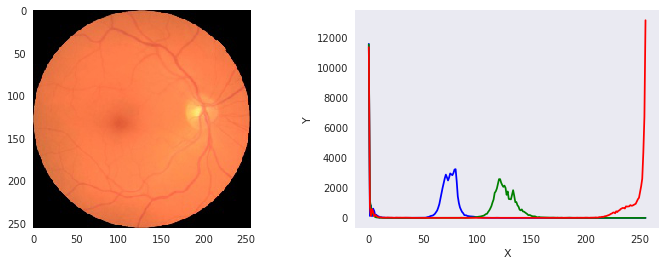

In [32]:
img = cv2.imread(cropped_image_path + '/' + sample_img)
b,g,r = cv2.split(img)
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.imshow(img[...,::-1])
ax = fig.add_subplot(122)
for x, c in zip([b,g,r], ["b", "g", "r"]):
    xs = np.arange(256)
    ys = cv2.calcHist([x], [0], None, [256], [0,256])
    ax.plot(xs, ys.ravel(), color=c)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

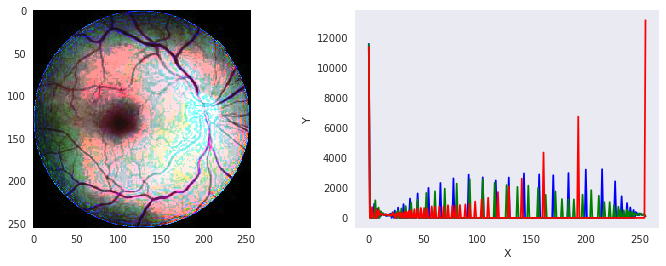

In [33]:
img = cv2.imread(cropped_image_path + '/' + sample_img)
b,g,r = cv2.split(histogram_equalize(img))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.imshow(histogram_equalize(img)[...,::-1])
ax = fig.add_subplot(122)
for x, c in zip([b,g,r], ["b", "g", "r"]):
    xs = np.arange(256)
    ys = cv2.calcHist([x], [0], None, [256], [0,256])
    ax.plot(xs, ys.ravel(), color=c)
ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [34]:
#Convert all cropped images into HE images
index = 0
for file in os.listdir(cropped_image_path):
    index = index + 1
    img_full_path = os.path.join(cropped_image_path, file)
    img = cv2.imread(img_full_path)
    Histogram_Equalisation_image_full_path = os.path.join(HE_path, file)
    cv2.imwrite(Histogram_Equalisation_image_full_path, histogram_equalize(img)[...,::-1])
    print(index, ' : ', Histogram_Equalisation_image_full_path)

1  :  /mnt/disks/user/project/Sample HE/1955_right.jpeg
2  :  /mnt/disks/user/project/Sample HE/4514_right.jpeg
3  :  /mnt/disks/user/project/Sample HE/5285_right.jpeg
4  :  /mnt/disks/user/project/Sample HE/3434_left.jpeg
5  :  /mnt/disks/user/project/Sample HE/1667_left.jpeg
6  :  /mnt/disks/user/project/Sample HE/412_right.jpeg
7  :  /mnt/disks/user/project/Sample HE/803_left.jpeg
8  :  /mnt/disks/user/project/Sample HE/2605_left.jpeg
9  :  /mnt/disks/user/project/Sample HE/20_left.jpeg
10  :  /mnt/disks/user/project/Sample HE/33_left.jpeg
11  :  /mnt/disks/user/project/Sample HE/320_left.jpeg
12  :  /mnt/disks/user/project/Sample HE/1469_right.jpeg
13  :  /mnt/disks/user/project/Sample HE/4802_left.jpeg
14  :  /mnt/disks/user/project/Sample HE/5146_right.jpeg
15  :  /mnt/disks/user/project/Sample HE/1017_left.jpeg
16  :  /mnt/disks/user/project/Sample HE/4800_left.jpeg
17  :  /mnt/disks/user/project/Sample HE/2124_right.jpeg
18  :  /mnt/disks/user/project/Sample HE/5145_right.jpeg


155  :  /mnt/disks/user/project/Sample HE/4195_left.jpeg
156  :  /mnt/disks/user/project/Sample HE/1920_left.jpeg
157  :  /mnt/disks/user/project/Sample HE/1302_left.jpeg
158  :  /mnt/disks/user/project/Sample HE/1324_left.jpeg
159  :  /mnt/disks/user/project/Sample HE/483_left.jpeg
160  :  /mnt/disks/user/project/Sample HE/3325_right.jpeg
161  :  /mnt/disks/user/project/Sample HE/4206_right.jpeg
162  :  /mnt/disks/user/project/Sample HE/1752_right.jpeg
163  :  /mnt/disks/user/project/Sample HE/3880_right.jpeg
164  :  /mnt/disks/user/project/Sample HE/706_right.jpeg
165  :  /mnt/disks/user/project/Sample HE/4134_right.jpeg
166  :  /mnt/disks/user/project/Sample HE/3892_right.jpeg
167  :  /mnt/disks/user/project/Sample HE/4098_left.jpeg
168  :  /mnt/disks/user/project/Sample HE/3461_left.jpeg
169  :  /mnt/disks/user/project/Sample HE/5070_left.jpeg
170  :  /mnt/disks/user/project/Sample HE/3657_right.jpeg
171  :  /mnt/disks/user/project/Sample HE/4066_right.jpeg
172  :  /mnt/disks/user/

314  :  /mnt/disks/user/project/Sample HE/3446_left.jpeg
315  :  /mnt/disks/user/project/Sample HE/3652_right.jpeg
316  :  /mnt/disks/user/project/Sample HE/1910_right.jpeg
317  :  /mnt/disks/user/project/Sample HE/22_right.jpeg
318  :  /mnt/disks/user/project/Sample HE/5742_left.jpeg
319  :  /mnt/disks/user/project/Sample HE/2358_left.jpeg
320  :  /mnt/disks/user/project/Sample HE/2992_left.jpeg
321  :  /mnt/disks/user/project/Sample HE/4070_left.jpeg
322  :  /mnt/disks/user/project/Sample HE/5824_left.jpeg
323  :  /mnt/disks/user/project/Sample HE/2767_left.jpeg
324  :  /mnt/disks/user/project/Sample HE/210_right.jpeg
325  :  /mnt/disks/user/project/Sample HE/5563_left.jpeg
326  :  /mnt/disks/user/project/Sample HE/3326_right.jpeg
327  :  /mnt/disks/user/project/Sample HE/5453_left.jpeg
328  :  /mnt/disks/user/project/Sample HE/2247_right.jpeg
329  :  /mnt/disks/user/project/Sample HE/780_right.jpeg
330  :  /mnt/disks/user/project/Sample HE/5757_left.jpeg
331  :  /mnt/disks/user/proj

473  :  /mnt/disks/user/project/Sample HE/2339_right.jpeg
474  :  /mnt/disks/user/project/Sample HE/678_right.jpeg
475  :  /mnt/disks/user/project/Sample HE/4497_left.jpeg
476  :  /mnt/disks/user/project/Sample HE/3892_left.jpeg
477  :  /mnt/disks/user/project/Sample HE/3228_left.jpeg
478  :  /mnt/disks/user/project/Sample HE/682_right.jpeg
479  :  /mnt/disks/user/project/Sample HE/3523_left.jpeg
480  :  /mnt/disks/user/project/Sample HE/5134_left.jpeg
481  :  /mnt/disks/user/project/Sample HE/621_right.jpeg
482  :  /mnt/disks/user/project/Sample HE/2880_left.jpeg
483  :  /mnt/disks/user/project/Sample HE/5275_left.jpeg
484  :  /mnt/disks/user/project/Sample HE/3754_left.jpeg
485  :  /mnt/disks/user/project/Sample HE/4269_left.jpeg
486  :  /mnt/disks/user/project/Sample HE/1991_left.jpeg
487  :  /mnt/disks/user/project/Sample HE/1741_left.jpeg
488  :  /mnt/disks/user/project/Sample HE/13_right.jpeg
489  :  /mnt/disks/user/project/Sample HE/1378_right.jpeg
490  :  /mnt/disks/user/projec

633  :  /mnt/disks/user/project/Sample HE/3897_right.jpeg
634  :  /mnt/disks/user/project/Sample HE/2437_left.jpeg
635  :  /mnt/disks/user/project/Sample HE/5387_right.jpeg
636  :  /mnt/disks/user/project/Sample HE/5013_right.jpeg
637  :  /mnt/disks/user/project/Sample HE/2735_left.jpeg
638  :  /mnt/disks/user/project/Sample HE/2359_right.jpeg
639  :  /mnt/disks/user/project/Sample HE/1540_left.jpeg
640  :  /mnt/disks/user/project/Sample HE/3808_right.jpeg
641  :  /mnt/disks/user/project/Sample HE/1387_left.jpeg
642  :  /mnt/disks/user/project/Sample HE/1878_left.jpeg
643  :  /mnt/disks/user/project/Sample HE/607_right.jpeg
644  :  /mnt/disks/user/project/Sample HE/3382_left.jpeg
645  :  /mnt/disks/user/project/Sample HE/99_left.jpeg
646  :  /mnt/disks/user/project/Sample HE/2243_right.jpeg
647  :  /mnt/disks/user/project/Sample HE/5319_right.jpeg
648  :  /mnt/disks/user/project/Sample HE/762_left.jpeg
649  :  /mnt/disks/user/project/Sample HE/5537_left.jpeg
650  :  /mnt/disks/user/pro

793  :  /mnt/disks/user/project/Sample HE/6227_left.jpeg
794  :  /mnt/disks/user/project/Sample HE/4698_left.jpeg
795  :  /mnt/disks/user/project/Sample HE/796_right.jpeg
796  :  /mnt/disks/user/project/Sample HE/5456_right.jpeg
797  :  /mnt/disks/user/project/Sample HE/4071_right.jpeg
798  :  /mnt/disks/user/project/Sample HE/95_left.jpeg
799  :  /mnt/disks/user/project/Sample HE/2534_left.jpeg
800  :  /mnt/disks/user/project/Sample HE/1488_left.jpeg
801  :  /mnt/disks/user/project/Sample HE/818_left.jpeg
802  :  /mnt/disks/user/project/Sample HE/2174_left.jpeg
803  :  /mnt/disks/user/project/Sample HE/5319_left.jpeg
804  :  /mnt/disks/user/project/Sample HE/5367_right.jpeg
805  :  /mnt/disks/user/project/Sample HE/1259_left.jpeg
806  :  /mnt/disks/user/project/Sample HE/2159_right.jpeg
807  :  /mnt/disks/user/project/Sample HE/6001_right.jpeg
808  :  /mnt/disks/user/project/Sample HE/1552_right.jpeg
809  :  /mnt/disks/user/project/Sample HE/3451_right.jpeg
810  :  /mnt/disks/user/pro

952  :  /mnt/disks/user/project/Sample HE/2451_left.jpeg
953  :  /mnt/disks/user/project/Sample HE/3000_left.jpeg
954  :  /mnt/disks/user/project/Sample HE/5655_right.jpeg
955  :  /mnt/disks/user/project/Sample HE/599_right.jpeg
956  :  /mnt/disks/user/project/Sample HE/2869_right.jpeg
957  :  /mnt/disks/user/project/Sample HE/3319_right.jpeg
958  :  /mnt/disks/user/project/Sample HE/4135_right.jpeg
959  :  /mnt/disks/user/project/Sample HE/3580_right.jpeg
960  :  /mnt/disks/user/project/Sample HE/1424_left.jpeg
961  :  /mnt/disks/user/project/Sample HE/70_right.jpeg
962  :  /mnt/disks/user/project/Sample HE/3743_right.jpeg
963  :  /mnt/disks/user/project/Sample HE/800_right.jpeg
964  :  /mnt/disks/user/project/Sample HE/4805_left.jpeg
965  :  /mnt/disks/user/project/Sample HE/1333_left.jpeg
966  :  /mnt/disks/user/project/Sample HE/2199_right.jpeg
967  :  /mnt/disks/user/project/Sample HE/3174_left.jpeg
968  :  /mnt/disks/user/project/Sample HE/6207_right.jpeg
969  :  /mnt/disks/user/

1111  :  /mnt/disks/user/project/Sample HE/3130_right.jpeg
1112  :  /mnt/disks/user/project/Sample HE/3752_right.jpeg
1113  :  /mnt/disks/user/project/Sample HE/3379_right.jpeg
1114  :  /mnt/disks/user/project/Sample HE/5296_right.jpeg
1115  :  /mnt/disks/user/project/Sample HE/1710_left.jpeg
1116  :  /mnt/disks/user/project/Sample HE/317_right.jpeg
1117  :  /mnt/disks/user/project/Sample HE/1659_left.jpeg
1118  :  /mnt/disks/user/project/Sample HE/3356_left.jpeg
1119  :  /mnt/disks/user/project/Sample HE/3907_left.jpeg
1120  :  /mnt/disks/user/project/Sample HE/604_right.jpeg
1121  :  /mnt/disks/user/project/Sample HE/1991_right.jpeg
1122  :  /mnt/disks/user/project/Sample HE/6022_left.jpeg
1123  :  /mnt/disks/user/project/Sample HE/241_left.jpeg
1124  :  /mnt/disks/user/project/Sample HE/2303_right.jpeg
1125  :  /mnt/disks/user/project/Sample HE/2363_right.jpeg
1126  :  /mnt/disks/user/project/Sample HE/378_right.jpeg
1127  :  /mnt/disks/user/project/Sample HE/5283_left.jpeg
1128  : 

1269  :  /mnt/disks/user/project/Sample HE/5772_left.jpeg
1270  :  /mnt/disks/user/project/Sample HE/4129_left.jpeg
1271  :  /mnt/disks/user/project/Sample HE/2286_right.jpeg
1272  :  /mnt/disks/user/project/Sample HE/6005_right.jpeg
1273  :  /mnt/disks/user/project/Sample HE/5685_left.jpeg
1274  :  /mnt/disks/user/project/Sample HE/2785_right.jpeg
1275  :  /mnt/disks/user/project/Sample HE/2433_left.jpeg
1276  :  /mnt/disks/user/project/Sample HE/3542_right.jpeg
1277  :  /mnt/disks/user/project/Sample HE/4181_right.jpeg
1278  :  /mnt/disks/user/project/Sample HE/2553_right.jpeg
1279  :  /mnt/disks/user/project/Sample HE/5014_right.jpeg
1280  :  /mnt/disks/user/project/Sample HE/4506_left.jpeg
1281  :  /mnt/disks/user/project/Sample HE/685_left.jpeg
1282  :  /mnt/disks/user/project/Sample HE/3029_left.jpeg
1283  :  /mnt/disks/user/project/Sample HE/1810_left.jpeg
1284  :  /mnt/disks/user/project/Sample HE/405_left.jpeg
1285  :  /mnt/disks/user/project/Sample HE/3365_left.jpeg
1286  :  

1425  :  /mnt/disks/user/project/Sample HE/2399_left.jpeg
1426  :  /mnt/disks/user/project/Sample HE/2227_left.jpeg
1427  :  /mnt/disks/user/project/Sample HE/4255_left.jpeg
1428  :  /mnt/disks/user/project/Sample HE/3508_right.jpeg
1429  :  /mnt/disks/user/project/Sample HE/2329_left.jpeg
1430  :  /mnt/disks/user/project/Sample HE/4901_right.jpeg
1431  :  /mnt/disks/user/project/Sample HE/4285_left.jpeg
1432  :  /mnt/disks/user/project/Sample HE/3271_right.jpeg
1433  :  /mnt/disks/user/project/Sample HE/6015_right.jpeg
1434  :  /mnt/disks/user/project/Sample HE/6245_right.jpeg
1435  :  /mnt/disks/user/project/Sample HE/5559_right.jpeg
1436  :  /mnt/disks/user/project/Sample HE/4307_left.jpeg
1437  :  /mnt/disks/user/project/Sample HE/534_right.jpeg
1438  :  /mnt/disks/user/project/Sample HE/2604_left.jpeg
1439  :  /mnt/disks/user/project/Sample HE/5324_right.jpeg
1440  :  /mnt/disks/user/project/Sample HE/4838_right.jpeg
1441  :  /mnt/disks/user/project/Sample HE/4959_left.jpeg
1442  

1580  :  /mnt/disks/user/project/Sample HE/3727_right.jpeg
1581  :  /mnt/disks/user/project/Sample HE/2774_left.jpeg
1582  :  /mnt/disks/user/project/Sample HE/3059_right.jpeg
1583  :  /mnt/disks/user/project/Sample HE/2047_left.jpeg
1584  :  /mnt/disks/user/project/Sample HE/167_left.jpeg
1585  :  /mnt/disks/user/project/Sample HE/1609_left.jpeg
1586  :  /mnt/disks/user/project/Sample HE/6251_right.jpeg
1587  :  /mnt/disks/user/project/Sample HE/3762_left.jpeg
1588  :  /mnt/disks/user/project/Sample HE/5900_right.jpeg
1589  :  /mnt/disks/user/project/Sample HE/3000_right.jpeg
1590  :  /mnt/disks/user/project/Sample HE/1893_left.jpeg
1591  :  /mnt/disks/user/project/Sample HE/5947_left.jpeg
1592  :  /mnt/disks/user/project/Sample HE/4657_right.jpeg
1593  :  /mnt/disks/user/project/Sample HE/1933_left.jpeg
1594  :  /mnt/disks/user/project/Sample HE/715_right.jpeg
1595  :  /mnt/disks/user/project/Sample HE/5911_left.jpeg
1596  :  /mnt/disks/user/project/Sample HE/2677_left.jpeg
1597  :  

1731  :  /mnt/disks/user/project/Sample HE/338_left.jpeg
1732  :  /mnt/disks/user/project/Sample HE/645_right.jpeg
1733  :  /mnt/disks/user/project/Sample HE/3423_left.jpeg
1734  :  /mnt/disks/user/project/Sample HE/3773_left.jpeg
1735  :  /mnt/disks/user/project/Sample HE/998_left.jpeg
1736  :  /mnt/disks/user/project/Sample HE/5598_right.jpeg
1737  :  /mnt/disks/user/project/Sample HE/2169_left.jpeg
1738  :  /mnt/disks/user/project/Sample HE/5500_left.jpeg
1739  :  /mnt/disks/user/project/Sample HE/2058_left.jpeg
1740  :  /mnt/disks/user/project/Sample HE/4237_right.jpeg
1741  :  /mnt/disks/user/project/Sample HE/563_right.jpeg
1742  :  /mnt/disks/user/project/Sample HE/2999_left.jpeg
1743  :  /mnt/disks/user/project/Sample HE/3727_left.jpeg
1744  :  /mnt/disks/user/project/Sample HE/2768_left.jpeg
1745  :  /mnt/disks/user/project/Sample HE/3060_left.jpeg
1746  :  /mnt/disks/user/project/Sample HE/5559_left.jpeg
1747  :  /mnt/disks/user/project/Sample HE/698_right.jpeg
1748  :  /mnt/

1884  :  /mnt/disks/user/project/Sample HE/163_right.jpeg
1885  :  /mnt/disks/user/project/Sample HE/3846_right.jpeg
1886  :  /mnt/disks/user/project/Sample HE/4851_right.jpeg
1887  :  /mnt/disks/user/project/Sample HE/4838_left.jpeg
1888  :  /mnt/disks/user/project/Sample HE/1363_right.jpeg
1889  :  /mnt/disks/user/project/Sample HE/3043_left.jpeg
1890  :  /mnt/disks/user/project/Sample HE/2859_right.jpeg
1891  :  /mnt/disks/user/project/Sample HE/4070_right.jpeg
1892  :  /mnt/disks/user/project/Sample HE/5738_left.jpeg
1893  :  /mnt/disks/user/project/Sample HE/3275_left.jpeg
1894  :  /mnt/disks/user/project/Sample HE/5435_right.jpeg
1895  :  /mnt/disks/user/project/Sample HE/3434_right.jpeg
1896  :  /mnt/disks/user/project/Sample HE/5276_right.jpeg
1897  :  /mnt/disks/user/project/Sample HE/3022_left.jpeg
1898  :  /mnt/disks/user/project/Sample HE/42_right.jpeg
1899  :  /mnt/disks/user/project/Sample HE/4364_right.jpeg
1900  :  /mnt/disks/user/project/Sample HE/1353_right.jpeg
1901 

2046  :  /mnt/disks/user/project/Sample HE/2011_right.jpeg
2047  :  /mnt/disks/user/project/Sample HE/2564_right.jpeg
2048  :  /mnt/disks/user/project/Sample HE/2558_right.jpeg
2049  :  /mnt/disks/user/project/Sample HE/4366_right.jpeg
2050  :  /mnt/disks/user/project/Sample HE/2629_left.jpeg
2051  :  /mnt/disks/user/project/Sample HE/2963_right.jpeg
2052  :  /mnt/disks/user/project/Sample HE/4917_left.jpeg
2053  :  /mnt/disks/user/project/Sample HE/4658_right.jpeg
2054  :  /mnt/disks/user/project/Sample HE/3345_left.jpeg
2055  :  /mnt/disks/user/project/Sample HE/219_right.jpeg
2056  :  /mnt/disks/user/project/Sample HE/3706_left.jpeg
2057  :  /mnt/disks/user/project/Sample HE/1051_right.jpeg
2058  :  /mnt/disks/user/project/Sample HE/4711_right.jpeg
2059  :  /mnt/disks/user/project/Sample HE/288_right.jpeg
2060  :  /mnt/disks/user/project/Sample HE/3088_right.jpeg
2061  :  /mnt/disks/user/project/Sample HE/5141_right.jpeg
2062  :  /mnt/disks/user/project/Sample HE/4601_right.jpeg
206

2207  :  /mnt/disks/user/project/Sample HE/6136_left.jpeg
2208  :  /mnt/disks/user/project/Sample HE/438_left.jpeg
2209  :  /mnt/disks/user/project/Sample HE/2443_left.jpeg
2210  :  /mnt/disks/user/project/Sample HE/6062_right.jpeg
2211  :  /mnt/disks/user/project/Sample HE/2749_right.jpeg
2212  :  /mnt/disks/user/project/Sample HE/1839_left.jpeg
2213  :  /mnt/disks/user/project/Sample HE/2954_left.jpeg
2214  :  /mnt/disks/user/project/Sample HE/4290_left.jpeg
2215  :  /mnt/disks/user/project/Sample HE/3265_right.jpeg
2216  :  /mnt/disks/user/project/Sample HE/2258_left.jpeg
2217  :  /mnt/disks/user/project/Sample HE/2399_right.jpeg
2218  :  /mnt/disks/user/project/Sample HE/492_left.jpeg
2219  :  /mnt/disks/user/project/Sample HE/1188_left.jpeg
2220  :  /mnt/disks/user/project/Sample HE/1356_left.jpeg
2221  :  /mnt/disks/user/project/Sample HE/5140_left.jpeg
2222  :  /mnt/disks/user/project/Sample HE/2695_right.jpeg
2223  :  /mnt/disks/user/project/Sample HE/2362_left.jpeg
2224  :  /m

2365  :  /mnt/disks/user/project/Sample HE/17_left.jpeg
2366  :  /mnt/disks/user/project/Sample HE/5066_right.jpeg
2367  :  /mnt/disks/user/project/Sample HE/1178_left.jpeg
2368  :  /mnt/disks/user/project/Sample HE/1658_right.jpeg
2369  :  /mnt/disks/user/project/Sample HE/3989_right.jpeg
2370  :  /mnt/disks/user/project/Sample HE/1393_left.jpeg
2371  :  /mnt/disks/user/project/Sample HE/3558_left.jpeg
2372  :  /mnt/disks/user/project/Sample HE/4641_right.jpeg
2373  :  /mnt/disks/user/project/Sample HE/2970_right.jpeg
2374  :  /mnt/disks/user/project/Sample HE/2262_right.jpeg
2375  :  /mnt/disks/user/project/Sample HE/437_left.jpeg
2376  :  /mnt/disks/user/project/Sample HE/2285_right.jpeg
2377  :  /mnt/disks/user/project/Sample HE/1027_left.jpeg
2378  :  /mnt/disks/user/project/Sample HE/4490_right.jpeg
2379  :  /mnt/disks/user/project/Sample HE/5605_left.jpeg
2380  :  /mnt/disks/user/project/Sample HE/2129_right.jpeg
2381  :  /mnt/disks/user/project/Sample HE/1981_left.jpeg
2382  : 

2523  :  /mnt/disks/user/project/Sample HE/945_right.jpeg
2524  :  /mnt/disks/user/project/Sample HE/812_left.jpeg
2525  :  /mnt/disks/user/project/Sample HE/5421_right.jpeg
2526  :  /mnt/disks/user/project/Sample HE/1737_left.jpeg
2527  :  /mnt/disks/user/project/Sample HE/4784_left.jpeg
2528  :  /mnt/disks/user/project/Sample HE/2842_right.jpeg
2529  :  /mnt/disks/user/project/Sample HE/3914_right.jpeg
2530  :  /mnt/disks/user/project/Sample HE/3623_left.jpeg
2531  :  /mnt/disks/user/project/Sample HE/4909_right.jpeg
2532  :  /mnt/disks/user/project/Sample HE/1188_right.jpeg
2533  :  /mnt/disks/user/project/Sample HE/6085_left.jpeg
2534  :  /mnt/disks/user/project/Sample HE/636_right.jpeg
2535  :  /mnt/disks/user/project/Sample HE/5285_left.jpeg
2536  :  /mnt/disks/user/project/Sample HE/5497_left.jpeg
2537  :  /mnt/disks/user/project/Sample HE/5752_left.jpeg
2538  :  /mnt/disks/user/project/Sample HE/1098_right.jpeg
2539  :  /mnt/disks/user/project/Sample HE/259_right.jpeg
2540  :  

2683  :  /mnt/disks/user/project/Sample HE/1145_right.jpeg
2684  :  /mnt/disks/user/project/Sample HE/4282_left.jpeg
2685  :  /mnt/disks/user/project/Sample HE/79_left.jpeg
2686  :  /mnt/disks/user/project/Sample HE/4249_right.jpeg
2687  :  /mnt/disks/user/project/Sample HE/4329_left.jpeg
2688  :  /mnt/disks/user/project/Sample HE/1878_right.jpeg
2689  :  /mnt/disks/user/project/Sample HE/2107_right.jpeg
2690  :  /mnt/disks/user/project/Sample HE/2961_right.jpeg
2691  :  /mnt/disks/user/project/Sample HE/4434_right.jpeg
2692  :  /mnt/disks/user/project/Sample HE/4065_right.jpeg
2693  :  /mnt/disks/user/project/Sample HE/987_right.jpeg
2694  :  /mnt/disks/user/project/Sample HE/4946_right.jpeg
2695  :  /mnt/disks/user/project/Sample HE/1532_left.jpeg
2696  :  /mnt/disks/user/project/Sample HE/3011_left.jpeg
2697  :  /mnt/disks/user/project/Sample HE/3412_right.jpeg
2698  :  /mnt/disks/user/project/Sample HE/1680_right.jpeg
2699  :  /mnt/disks/user/project/Sample HE/1997_right.jpeg
2700 

2842  :  /mnt/disks/user/project/Sample HE/4916_right.jpeg
2843  :  /mnt/disks/user/project/Sample HE/3593_left.jpeg
2844  :  /mnt/disks/user/project/Sample HE/5471_right.jpeg
2845  :  /mnt/disks/user/project/Sample HE/3144_right.jpeg
2846  :  /mnt/disks/user/project/Sample HE/3358_right.jpeg
2847  :  /mnt/disks/user/project/Sample HE/5696_right.jpeg
2848  :  /mnt/disks/user/project/Sample HE/5877_right.jpeg
2849  :  /mnt/disks/user/project/Sample HE/431_right.jpeg
2850  :  /mnt/disks/user/project/Sample HE/19_right.jpeg
2851  :  /mnt/disks/user/project/Sample HE/3432_right.jpeg
2852  :  /mnt/disks/user/project/Sample HE/5435_left.jpeg
2853  :  /mnt/disks/user/project/Sample HE/5023_right.jpeg
2854  :  /mnt/disks/user/project/Sample HE/5816_right.jpeg
2855  :  /mnt/disks/user/project/Sample HE/4694_right.jpeg
2856  :  /mnt/disks/user/project/Sample HE/3530_left.jpeg
2857  :  /mnt/disks/user/project/Sample HE/3960_left.jpeg
2858  :  /mnt/disks/user/project/Sample HE/2957_left.jpeg
2859 

3000  :  /mnt/disks/user/project/Sample HE/2815_right.jpeg
3001  :  /mnt/disks/user/project/Sample HE/4323_left.jpeg
3002  :  /mnt/disks/user/project/Sample HE/625_right.jpeg
3003  :  /mnt/disks/user/project/Sample HE/5465_left.jpeg
3004  :  /mnt/disks/user/project/Sample HE/6163_right.jpeg
3005  :  /mnt/disks/user/project/Sample HE/2059_left.jpeg
3006  :  /mnt/disks/user/project/Sample HE/517_left.jpeg
3007  :  /mnt/disks/user/project/Sample HE/4095_right.jpeg
3008  :  /mnt/disks/user/project/Sample HE/762_right.jpeg
3009  :  /mnt/disks/user/project/Sample HE/3112_left.jpeg
3010  :  /mnt/disks/user/project/Sample HE/2357_left.jpeg
3011  :  /mnt/disks/user/project/Sample HE/1056_left.jpeg
3012  :  /mnt/disks/user/project/Sample HE/1313_right.jpeg
3013  :  /mnt/disks/user/project/Sample HE/5386_right.jpeg
3014  :  /mnt/disks/user/project/Sample HE/4769_right.jpeg
3015  :  /mnt/disks/user/project/Sample HE/650_right.jpeg
3016  :  /mnt/disks/user/project/Sample HE/1172_right.jpeg
3017  : 

3161  :  /mnt/disks/user/project/Sample HE/5838_left.jpeg
3162  :  /mnt/disks/user/project/Sample HE/3889_left.jpeg
3163  :  /mnt/disks/user/project/Sample HE/4754_left.jpeg
3164  :  /mnt/disks/user/project/Sample HE/4735_left.jpeg
3165  :  /mnt/disks/user/project/Sample HE/4009_right.jpeg
3166  :  /mnt/disks/user/project/Sample HE/5293_left.jpeg
3167  :  /mnt/disks/user/project/Sample HE/5788_right.jpeg
3168  :  /mnt/disks/user/project/Sample HE/1785_left.jpeg
3169  :  /mnt/disks/user/project/Sample HE/2860_left.jpeg
3170  :  /mnt/disks/user/project/Sample HE/2814_left.jpeg
3171  :  /mnt/disks/user/project/Sample HE/4437_right.jpeg
3172  :  /mnt/disks/user/project/Sample HE/2054_left.jpeg
3173  :  /mnt/disks/user/project/Sample HE/3347_right.jpeg
3174  :  /mnt/disks/user/project/Sample HE/2824_left.jpeg
3175  :  /mnt/disks/user/project/Sample HE/1736_right.jpeg
3176  :  /mnt/disks/user/project/Sample HE/508_left.jpeg
3177  :  /mnt/disks/user/project/Sample HE/400_left.jpeg
3178  :  /m

3318  :  /mnt/disks/user/project/Sample HE/940_left.jpeg
3319  :  /mnt/disks/user/project/Sample HE/2613_left.jpeg
3320  :  /mnt/disks/user/project/Sample HE/1764_left.jpeg
3321  :  /mnt/disks/user/project/Sample HE/2404_right.jpeg
3322  :  /mnt/disks/user/project/Sample HE/839_left.jpeg
3323  :  /mnt/disks/user/project/Sample HE/5095_left.jpeg
3324  :  /mnt/disks/user/project/Sample HE/6131_right.jpeg
3325  :  /mnt/disks/user/project/Sample HE/239_left.jpeg
3326  :  /mnt/disks/user/project/Sample HE/3778_right.jpeg
3327  :  /mnt/disks/user/project/Sample HE/4973_left.jpeg
3328  :  /mnt/disks/user/project/Sample HE/3829_left.jpeg
3329  :  /mnt/disks/user/project/Sample HE/6276_left.jpeg
3330  :  /mnt/disks/user/project/Sample HE/3167_right.jpeg
3331  :  /mnt/disks/user/project/Sample HE/1999_right.jpeg
3332  :  /mnt/disks/user/project/Sample HE/3653_left.jpeg
3333  :  /mnt/disks/user/project/Sample HE/432_right.jpeg
3334  :  /mnt/disks/user/project/Sample HE/3329_right.jpeg
3335  :  /m

3471  :  /mnt/disks/user/project/Sample HE/5423_right.jpeg
3472  :  /mnt/disks/user/project/Sample HE/3064_right.jpeg
3473  :  /mnt/disks/user/project/Sample HE/604_left.jpeg
3474  :  /mnt/disks/user/project/Sample HE/2262_left.jpeg
3475  :  /mnt/disks/user/project/Sample HE/174_left.jpeg
3476  :  /mnt/disks/user/project/Sample HE/1196_right.jpeg
3477  :  /mnt/disks/user/project/Sample HE/4850_right.jpeg
3478  :  /mnt/disks/user/project/Sample HE/6089_right.jpeg
3479  :  /mnt/disks/user/project/Sample HE/1070_right.jpeg
3480  :  /mnt/disks/user/project/Sample HE/2332_left.jpeg
3481  :  /mnt/disks/user/project/Sample HE/4659_left.jpeg
3482  :  /mnt/disks/user/project/Sample HE/4069_right.jpeg
3483  :  /mnt/disks/user/project/Sample HE/3459_right.jpeg
3484  :  /mnt/disks/user/project/Sample HE/904_left.jpeg
3485  :  /mnt/disks/user/project/Sample HE/289_right.jpeg
3486  :  /mnt/disks/user/project/Sample HE/4424_left.jpeg
3487  :  /mnt/disks/user/project/Sample HE/783_left.jpeg
3488  :  /

3626  :  /mnt/disks/user/project/Sample HE/2566_right.jpeg
3627  :  /mnt/disks/user/project/Sample HE/5878_left.jpeg
3628  :  /mnt/disks/user/project/Sample HE/910_left.jpeg
3629  :  /mnt/disks/user/project/Sample HE/4484_left.jpeg
3630  :  /mnt/disks/user/project/Sample HE/2401_left.jpeg
3631  :  /mnt/disks/user/project/Sample HE/615_right.jpeg
3632  :  /mnt/disks/user/project/Sample HE/2296_right.jpeg
3633  :  /mnt/disks/user/project/Sample HE/4191_right.jpeg
3634  :  /mnt/disks/user/project/Sample HE/6165_right.jpeg
3635  :  /mnt/disks/user/project/Sample HE/314_left.jpeg
3636  :  /mnt/disks/user/project/Sample HE/2435_left.jpeg
3637  :  /mnt/disks/user/project/Sample HE/5819_left.jpeg
3638  :  /mnt/disks/user/project/Sample HE/13_left.jpeg
3639  :  /mnt/disks/user/project/Sample HE/49_right.jpeg
3640  :  /mnt/disks/user/project/Sample HE/3766_right.jpeg
3641  :  /mnt/disks/user/project/Sample HE/4035_right.jpeg
3642  :  /mnt/disks/user/project/Sample HE/4261_left.jpeg
3643  :  /mnt

3780  :  /mnt/disks/user/project/Sample HE/3067_left.jpeg
3781  :  /mnt/disks/user/project/Sample HE/186_right.jpeg
3782  :  /mnt/disks/user/project/Sample HE/1663_left.jpeg
3783  :  /mnt/disks/user/project/Sample HE/5577_right.jpeg
3784  :  /mnt/disks/user/project/Sample HE/1307_left.jpeg
3785  :  /mnt/disks/user/project/Sample HE/3600_left.jpeg
3786  :  /mnt/disks/user/project/Sample HE/3405_left.jpeg
3787  :  /mnt/disks/user/project/Sample HE/4922_right.jpeg
3788  :  /mnt/disks/user/project/Sample HE/5757_right.jpeg
3789  :  /mnt/disks/user/project/Sample HE/2190_right.jpeg
3790  :  /mnt/disks/user/project/Sample HE/316_left.jpeg
3791  :  /mnt/disks/user/project/Sample HE/3653_right.jpeg
3792  :  /mnt/disks/user/project/Sample HE/122_right.jpeg
3793  :  /mnt/disks/user/project/Sample HE/1425_right.jpeg
3794  :  /mnt/disks/user/project/Sample HE/5018_right.jpeg
3795  :  /mnt/disks/user/project/Sample HE/1113_right.jpeg
3796  :  /mnt/disks/user/project/Sample HE/5715_right.jpeg
3797  

3932  :  /mnt/disks/user/project/Sample HE/3868_right.jpeg
3933  :  /mnt/disks/user/project/Sample HE/4915_left.jpeg
3934  :  /mnt/disks/user/project/Sample HE/81_right.jpeg
3935  :  /mnt/disks/user/project/Sample HE/1955_left.jpeg
3936  :  /mnt/disks/user/project/Sample HE/5680_left.jpeg
3937  :  /mnt/disks/user/project/Sample HE/6032_left.jpeg
3938  :  /mnt/disks/user/project/Sample HE/3076_right.jpeg
3939  :  /mnt/disks/user/project/Sample HE/2795_left.jpeg
3940  :  /mnt/disks/user/project/Sample HE/1508_left.jpeg
3941  :  /mnt/disks/user/project/Sample HE/6014_left.jpeg
3942  :  /mnt/disks/user/project/Sample HE/3104_left.jpeg
3943  :  /mnt/disks/user/project/Sample HE/2724_left.jpeg
3944  :  /mnt/disks/user/project/Sample HE/2159_left.jpeg
3945  :  /mnt/disks/user/project/Sample HE/4202_right.jpeg
3946  :  /mnt/disks/user/project/Sample HE/3802_left.jpeg
3947  :  /mnt/disks/user/project/Sample HE/5541_right.jpeg
3948  :  /mnt/disks/user/project/Sample HE/5318_right.jpeg
3949  :  /

4085  :  /mnt/disks/user/project/Sample HE/3749_left.jpeg
4086  :  /mnt/disks/user/project/Sample HE/5533_left.jpeg
4087  :  /mnt/disks/user/project/Sample HE/3401_right.jpeg
4088  :  /mnt/disks/user/project/Sample HE/731_right.jpeg
4089  :  /mnt/disks/user/project/Sample HE/3973_left.jpeg
4090  :  /mnt/disks/user/project/Sample HE/3453_left.jpeg
4091  :  /mnt/disks/user/project/Sample HE/2401_right.jpeg
4092  :  /mnt/disks/user/project/Sample HE/728_left.jpeg
4093  :  /mnt/disks/user/project/Sample HE/3462_right.jpeg
4094  :  /mnt/disks/user/project/Sample HE/4270_right.jpeg
4095  :  /mnt/disks/user/project/Sample HE/1283_left.jpeg
4096  :  /mnt/disks/user/project/Sample HE/5492_right.jpeg
4097  :  /mnt/disks/user/project/Sample HE/4498_left.jpeg
4098  :  /mnt/disks/user/project/Sample HE/2734_right.jpeg
4099  :  /mnt/disks/user/project/Sample HE/1853_left.jpeg
4100  :  /mnt/disks/user/project/Sample HE/851_right.jpeg
4101  :  /mnt/disks/user/project/Sample HE/5885_right.jpeg
4102  : 

4241  :  /mnt/disks/user/project/Sample HE/985_right.jpeg
4242  :  /mnt/disks/user/project/Sample HE/6148_left.jpeg
4243  :  /mnt/disks/user/project/Sample HE/799_left.jpeg
4244  :  /mnt/disks/user/project/Sample HE/3276_right.jpeg
4245  :  /mnt/disks/user/project/Sample HE/1557_right.jpeg
4246  :  /mnt/disks/user/project/Sample HE/5913_left.jpeg
4247  :  /mnt/disks/user/project/Sample HE/3572_right.jpeg
4248  :  /mnt/disks/user/project/Sample HE/2946_right.jpeg
4249  :  /mnt/disks/user/project/Sample HE/5436_right.jpeg
4250  :  /mnt/disks/user/project/Sample HE/2806_right.jpeg
4251  :  /mnt/disks/user/project/Sample HE/2561_left.jpeg
4252  :  /mnt/disks/user/project/Sample HE/5595_right.jpeg
4253  :  /mnt/disks/user/project/Sample HE/6217_right.jpeg
4254  :  /mnt/disks/user/project/Sample HE/31_left.jpeg
4255  :  /mnt/disks/user/project/Sample HE/4496_right.jpeg
4256  :  /mnt/disks/user/project/Sample HE/3868_left.jpeg
4257  :  /mnt/disks/user/project/Sample HE/5725_left.jpeg
4258  : 

4399  :  /mnt/disks/user/project/Sample HE/2918_right.jpeg
4400  :  /mnt/disks/user/project/Sample HE/3779_right.jpeg
4401  :  /mnt/disks/user/project/Sample HE/3769_right.jpeg
4402  :  /mnt/disks/user/project/Sample HE/844_right.jpeg
4403  :  /mnt/disks/user/project/Sample HE/2535_left.jpeg
4404  :  /mnt/disks/user/project/Sample HE/2607_right.jpeg
4405  :  /mnt/disks/user/project/Sample HE/6166_right.jpeg
4406  :  /mnt/disks/user/project/Sample HE/1765_left.jpeg
4407  :  /mnt/disks/user/project/Sample HE/2223_left.jpeg
4408  :  /mnt/disks/user/project/Sample HE/5837_left.jpeg
4409  :  /mnt/disks/user/project/Sample HE/4005_right.jpeg
4410  :  /mnt/disks/user/project/Sample HE/2430_left.jpeg
4411  :  /mnt/disks/user/project/Sample HE/2332_right.jpeg
4412  :  /mnt/disks/user/project/Sample HE/2984_right.jpeg
4413  :  /mnt/disks/user/project/Sample HE/217_left.jpeg
4414  :  /mnt/disks/user/project/Sample HE/82_right.jpeg
4415  :  /mnt/disks/user/project/Sample HE/557_left.jpeg
4416  :  

4555  :  /mnt/disks/user/project/Sample HE/2947_left.jpeg
4556  :  /mnt/disks/user/project/Sample HE/2226_left.jpeg
4557  :  /mnt/disks/user/project/Sample HE/4732_left.jpeg
4558  :  /mnt/disks/user/project/Sample HE/3023_right.jpeg
4559  :  /mnt/disks/user/project/Sample HE/1667_right.jpeg
4560  :  /mnt/disks/user/project/Sample HE/660_right.jpeg
4561  :  /mnt/disks/user/project/Sample HE/2648_left.jpeg
4562  :  /mnt/disks/user/project/Sample HE/329_left.jpeg
4563  :  /mnt/disks/user/project/Sample HE/1204_left.jpeg
4564  :  /mnt/disks/user/project/Sample HE/6163_left.jpeg
4565  :  /mnt/disks/user/project/Sample HE/5824_right.jpeg
4566  :  /mnt/disks/user/project/Sample HE/2550_left.jpeg
4567  :  /mnt/disks/user/project/Sample HE/958_left.jpeg
4568  :  /mnt/disks/user/project/Sample HE/4294_left.jpeg
4569  :  /mnt/disks/user/project/Sample HE/4130_right.jpeg
4570  :  /mnt/disks/user/project/Sample HE/4403_left.jpeg
4571  :  /mnt/disks/user/project/Sample HE/3417_left.jpeg
4572  :  /mn

4710  :  /mnt/disks/user/project/Sample HE/994_right.jpeg
4711  :  /mnt/disks/user/project/Sample HE/3693_right.jpeg
4712  :  /mnt/disks/user/project/Sample HE/5178_left.jpeg
4713  :  /mnt/disks/user/project/Sample HE/1776_right.jpeg
4714  :  /mnt/disks/user/project/Sample HE/1242_left.jpeg
4715  :  /mnt/disks/user/project/Sample HE/1351_right.jpeg
4716  :  /mnt/disks/user/project/Sample HE/2905_right.jpeg
4717  :  /mnt/disks/user/project/Sample HE/1399_right.jpeg
4718  :  /mnt/disks/user/project/Sample HE/6290_right.jpeg
4719  :  /mnt/disks/user/project/Sample HE/4563_right.jpeg
4720  :  /mnt/disks/user/project/Sample HE/5336_right.jpeg
4721  :  /mnt/disks/user/project/Sample HE/2515_right.jpeg
4722  :  /mnt/disks/user/project/Sample HE/3831_right.jpeg
4723  :  /mnt/disks/user/project/Sample HE/4689_left.jpeg
4724  :  /mnt/disks/user/project/Sample HE/4475_right.jpeg
4725  :  /mnt/disks/user/project/Sample HE/2964_right.jpeg
4726  :  /mnt/disks/user/project/Sample HE/6207_left.jpeg
47

4866  :  /mnt/disks/user/project/Sample HE/5009_left.jpeg
4867  :  /mnt/disks/user/project/Sample HE/613_right.jpeg
4868  :  /mnt/disks/user/project/Sample HE/4702_right.jpeg
4869  :  /mnt/disks/user/project/Sample HE/4844_right.jpeg
4870  :  /mnt/disks/user/project/Sample HE/4116_right.jpeg
4871  :  /mnt/disks/user/project/Sample HE/5316_left.jpeg
4872  :  /mnt/disks/user/project/Sample HE/706_left.jpeg
4873  :  /mnt/disks/user/project/Sample HE/2384_left.jpeg
4874  :  /mnt/disks/user/project/Sample HE/4531_right.jpeg
4875  :  /mnt/disks/user/project/Sample HE/322_right.jpeg
4876  :  /mnt/disks/user/project/Sample HE/820_left.jpeg
4877  :  /mnt/disks/user/project/Sample HE/4163_right.jpeg
4878  :  /mnt/disks/user/project/Sample HE/3758_right.jpeg
4879  :  /mnt/disks/user/project/Sample HE/2008_left.jpeg
4880  :  /mnt/disks/user/project/Sample HE/5041_left.jpeg
4881  :  /mnt/disks/user/project/Sample HE/1743_right.jpeg
4882  :  /mnt/disks/user/project/Sample HE/4887_right.jpeg
4883  : 

# CLAHE 

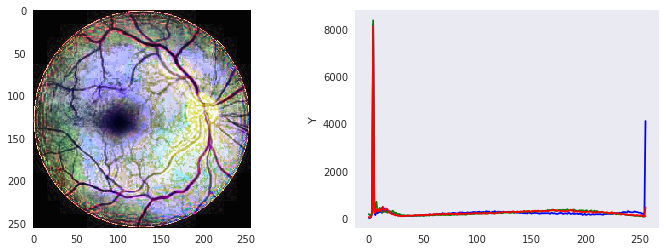

In [35]:
clip_limit=2.0
tile_size=8
img = cv2.imread(HE_path + '/' + sample_img)
b,g,r = cv2.split(CLAHE(img))
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(121)
ax.imshow(CLAHE(img[...,::-1]))
ax = fig.add_subplot(122)
for x, c in zip([b,g,r], ["b", "g", "r"]):
    xs = np.arange(256)
    ys = cv2.calcHist([x], [0], None, [256], [0,256])
    ax.plot(xs, ys.ravel(), color=c)
#ax.set_xlabel('X')
ax.set_ylabel('Y')
plt.show()

In [ ]:
#Convert all HE images in to CLAHE images
clip_limit=2.0
tile_size=8
index = 0
for file in os.listdir(HE_path):
    index = index + 1
    img_full_path = os.path.join(HE_path, file)
    #print(img_full_path)
    #img = cv2.imread(img_full_path)
    CLAHE_img_New_full_path = os.path.join(CLAHE_path, file)
    bgr = clahe_rgb(img_full_path, clip_limit, tile_size)
    cv2.imwrite(CLAHE_img_New_full_path, bgr)
    print(index,' : ' , CLAHE_img_New_full_path)

1  :  /mnt/disks/user/project/Sample CLAHE/1955_right.jpeg
2  :  /mnt/disks/user/project/Sample CLAHE/4514_right.jpeg
3  :  /mnt/disks/user/project/Sample CLAHE/5285_right.jpeg
4  :  /mnt/disks/user/project/Sample CLAHE/3434_left.jpeg
5  :  /mnt/disks/user/project/Sample CLAHE/1667_left.jpeg
6  :  /mnt/disks/user/project/Sample CLAHE/412_right.jpeg
7  :  /mnt/disks/user/project/Sample CLAHE/803_left.jpeg
8  :  /mnt/disks/user/project/Sample CLAHE/2605_left.jpeg
9  :  /mnt/disks/user/project/Sample CLAHE/20_left.jpeg
10  :  /mnt/disks/user/project/Sample CLAHE/33_left.jpeg
11  :  /mnt/disks/user/project/Sample CLAHE/320_left.jpeg
12  :  /mnt/disks/user/project/Sample CLAHE/1469_right.jpeg
13  :  /mnt/disks/user/project/Sample CLAHE/4802_left.jpeg
14  :  /mnt/disks/user/project/Sample CLAHE/5146_right.jpeg
15  :  /mnt/disks/user/project/Sample CLAHE/1017_left.jpeg
16  :  /mnt/disks/user/project/Sample CLAHE/4800_left.jpeg
17  :  /mnt/disks/user/project/Sample CLAHE/2124_right.jpeg
18  : 

144  :  /mnt/disks/user/project/Sample CLAHE/4827_left.jpeg
145  :  /mnt/disks/user/project/Sample CLAHE/2865_left.jpeg
146  :  /mnt/disks/user/project/Sample CLAHE/203_left.jpeg
147  :  /mnt/disks/user/project/Sample CLAHE/1710_right.jpeg
148  :  /mnt/disks/user/project/Sample CLAHE/2606_right.jpeg
149  :  /mnt/disks/user/project/Sample CLAHE/1096_right.jpeg
150  :  /mnt/disks/user/project/Sample CLAHE/3393_left.jpeg
151  :  /mnt/disks/user/project/Sample CLAHE/1361_left.jpeg
152  :  /mnt/disks/user/project/Sample CLAHE/2338_left.jpeg
153  :  /mnt/disks/user/project/Sample CLAHE/3023_left.jpeg
154  :  /mnt/disks/user/project/Sample CLAHE/4518_left.jpeg
155  :  /mnt/disks/user/project/Sample CLAHE/4195_left.jpeg
156  :  /mnt/disks/user/project/Sample CLAHE/1920_left.jpeg
157  :  /mnt/disks/user/project/Sample CLAHE/1302_left.jpeg
158  :  /mnt/disks/user/project/Sample CLAHE/1324_left.jpeg
159  :  /mnt/disks/user/project/Sample CLAHE/483_left.jpeg
160  :  /mnt/disks/user/project/Sample 

300  :  /mnt/disks/user/project/Sample CLAHE/4479_right.jpeg
301  :  /mnt/disks/user/project/Sample CLAHE/4631_right.jpeg
302  :  /mnt/disks/user/project/Sample CLAHE/4158_left.jpeg
303  :  /mnt/disks/user/project/Sample CLAHE/5467_right.jpeg
304  :  /mnt/disks/user/project/Sample CLAHE/5194_left.jpeg
305  :  /mnt/disks/user/project/Sample CLAHE/323_right.jpeg
306  :  /mnt/disks/user/project/Sample CLAHE/4301_left.jpeg
307  :  /mnt/disks/user/project/Sample CLAHE/1395_right.jpeg
308  :  /mnt/disks/user/project/Sample CLAHE/5237_left.jpeg
309  :  /mnt/disks/user/project/Sample CLAHE/204_right.jpeg
310  :  /mnt/disks/user/project/Sample CLAHE/3706_right.jpeg
311  :  /mnt/disks/user/project/Sample CLAHE/4861_right.jpeg
312  :  /mnt/disks/user/project/Sample CLAHE/3851_right.jpeg
313  :  /mnt/disks/user/project/Sample CLAHE/5512_left.jpeg
314  :  /mnt/disks/user/project/Sample CLAHE/3446_left.jpeg
315  :  /mnt/disks/user/project/Sample CLAHE/3652_right.jpeg
316  :  /mnt/disks/user/project/

455  :  /mnt/disks/user/project/Sample CLAHE/3856_left.jpeg
456  :  /mnt/disks/user/project/Sample CLAHE/5396_left.jpeg
457  :  /mnt/disks/user/project/Sample CLAHE/5667_right.jpeg
458  :  /mnt/disks/user/project/Sample CLAHE/4444_left.jpeg
459  :  /mnt/disks/user/project/Sample CLAHE/740_left.jpeg
460  :  /mnt/disks/user/project/Sample CLAHE/2161_left.jpeg
461  :  /mnt/disks/user/project/Sample CLAHE/280_left.jpeg
462  :  /mnt/disks/user/project/Sample CLAHE/4878_right.jpeg
463  :  /mnt/disks/user/project/Sample CLAHE/3757_right.jpeg
464  :  /mnt/disks/user/project/Sample CLAHE/3721_right.jpeg
465  :  /mnt/disks/user/project/Sample CLAHE/5141_left.jpeg
466  :  /mnt/disks/user/project/Sample CLAHE/6272_left.jpeg
467  :  /mnt/disks/user/project/Sample CLAHE/5511_left.jpeg
468  :  /mnt/disks/user/project/Sample CLAHE/1856_left.jpeg
469  :  /mnt/disks/user/project/Sample CLAHE/3832_left.jpeg
470  :  /mnt/disks/user/project/Sample CLAHE/5355_left.jpeg
471  :  /mnt/disks/user/project/Sample

610  :  /mnt/disks/user/project/Sample CLAHE/3170_right.jpeg
611  :  /mnt/disks/user/project/Sample CLAHE/5009_right.jpeg
612  :  /mnt/disks/user/project/Sample CLAHE/4161_left.jpeg
613  :  /mnt/disks/user/project/Sample CLAHE/710_right.jpeg
614  :  /mnt/disks/user/project/Sample CLAHE/5807_right.jpeg
615  :  /mnt/disks/user/project/Sample CLAHE/5383_left.jpeg
616  :  /mnt/disks/user/project/Sample CLAHE/2136_right.jpeg
617  :  /mnt/disks/user/project/Sample CLAHE/2303_left.jpeg
618  :  /mnt/disks/user/project/Sample CLAHE/2031_left.jpeg
619  :  /mnt/disks/user/project/Sample CLAHE/2066_left.jpeg
620  :  /mnt/disks/user/project/Sample CLAHE/4658_left.jpeg
621  :  /mnt/disks/user/project/Sample CLAHE/412_left.jpeg
622  :  /mnt/disks/user/project/Sample CLAHE/2545_right.jpeg
623  :  /mnt/disks/user/project/Sample CLAHE/3598_left.jpeg
624  :  /mnt/disks/user/project/Sample CLAHE/3376_right.jpeg
625  :  /mnt/disks/user/project/Sample CLAHE/4779_left.jpeg
626  :  /mnt/disks/user/project/Sam

764  :  /mnt/disks/user/project/Sample CLAHE/6263_right.jpeg
765  :  /mnt/disks/user/project/Sample CLAHE/2080_left.jpeg
766  :  /mnt/disks/user/project/Sample CLAHE/3372_right.jpeg
767  :  /mnt/disks/user/project/Sample CLAHE/2534_right.jpeg
768  :  /mnt/disks/user/project/Sample CLAHE/2223_right.jpeg
769  :  /mnt/disks/user/project/Sample CLAHE/3423_right.jpeg
770  :  /mnt/disks/user/project/Sample CLAHE/4066_left.jpeg
771  :  /mnt/disks/user/project/Sample CLAHE/3096_right.jpeg
772  :  /mnt/disks/user/project/Sample CLAHE/5869_left.jpeg
773  :  /mnt/disks/user/project/Sample CLAHE/1808_right.jpeg
774  :  /mnt/disks/user/project/Sample CLAHE/1649_right.jpeg
775  :  /mnt/disks/user/project/Sample CLAHE/5295_left.jpeg
776  :  /mnt/disks/user/project/Sample CLAHE/4946_left.jpeg
777  :  /mnt/disks/user/project/Sample CLAHE/6298_left.jpeg
778  :  /mnt/disks/user/project/Sample CLAHE/4276_left.jpeg
779  :  /mnt/disks/user/project/Sample CLAHE/4086_right.jpeg
780  :  /mnt/disks/user/project

920  :  /mnt/disks/user/project/Sample CLAHE/1041_right.jpeg
921  :  /mnt/disks/user/project/Sample CLAHE/5515_right.jpeg
922  :  /mnt/disks/user/project/Sample CLAHE/905_left.jpeg
923  :  /mnt/disks/user/project/Sample CLAHE/3605_left.jpeg
924  :  /mnt/disks/user/project/Sample CLAHE/5916_right.jpeg
925  :  /mnt/disks/user/project/Sample CLAHE/4460_right.jpeg
926  :  /mnt/disks/user/project/Sample CLAHE/1752_left.jpeg
927  :  /mnt/disks/user/project/Sample CLAHE/4632_left.jpeg
928  :  /mnt/disks/user/project/Sample CLAHE/4139_left.jpeg
929  :  /mnt/disks/user/project/Sample CLAHE/2296_left.jpeg
930  :  /mnt/disks/user/project/Sample CLAHE/1449_right.jpeg
931  :  /mnt/disks/user/project/Sample CLAHE/494_left.jpeg
932  :  /mnt/disks/user/project/Sample CLAHE/6182_left.jpeg
933  :  /mnt/disks/user/project/Sample CLAHE/6010_left.jpeg
934  :  /mnt/disks/user/project/Sample CLAHE/5732_left.jpeg
935  :  /mnt/disks/user/project/Sample CLAHE/1370_left.jpeg
936  :  /mnt/disks/user/project/Sampl

1074  :  /mnt/disks/user/project/Sample CLAHE/1630_left.jpeg
1075  :  /mnt/disks/user/project/Sample CLAHE/2302_right.jpeg
1076  :  /mnt/disks/user/project/Sample CLAHE/6269_right.jpeg
1077  :  /mnt/disks/user/project/Sample CLAHE/4370_left.jpeg
1078  :  /mnt/disks/user/project/Sample CLAHE/5237_right.jpeg
1079  :  /mnt/disks/user/project/Sample CLAHE/2610_right.jpeg
1080  :  /mnt/disks/user/project/Sample CLAHE/1551_left.jpeg
1081  :  /mnt/disks/user/project/Sample CLAHE/1611_left.jpeg
1082  :  /mnt/disks/user/project/Sample CLAHE/2218_left.jpeg
1083  :  /mnt/disks/user/project/Sample CLAHE/4548_right.jpeg
1084  :  /mnt/disks/user/project/Sample CLAHE/5368_right.jpeg
1085  :  /mnt/disks/user/project/Sample CLAHE/3112_right.jpeg
1086  :  /mnt/disks/user/project/Sample CLAHE/5308_left.jpeg
1087  :  /mnt/disks/user/project/Sample CLAHE/5185_left.jpeg
1088  :  /mnt/disks/user/project/Sample CLAHE/1259_right.jpeg
1089  :  /mnt/disks/user/project/Sample CLAHE/3376_left.jpeg
1090  :  /mnt/di

1229  :  /mnt/disks/user/project/Sample CLAHE/5646_right.jpeg
1230  :  /mnt/disks/user/project/Sample CLAHE/745_right.jpeg
1231  :  /mnt/disks/user/project/Sample CLAHE/5112_left.jpeg
1232  :  /mnt/disks/user/project/Sample CLAHE/217_right.jpeg
1233  :  /mnt/disks/user/project/Sample CLAHE/6182_right.jpeg
1234  :  /mnt/disks/user/project/Sample CLAHE/2192_right.jpeg
1235  :  /mnt/disks/user/project/Sample CLAHE/3994_right.jpeg
1236  :  /mnt/disks/user/project/Sample CLAHE/5758_left.jpeg
1237  :  /mnt/disks/user/project/Sample CLAHE/3101_left.jpeg
1238  :  /mnt/disks/user/project/Sample CLAHE/2078_right.jpeg
1239  :  /mnt/disks/user/project/Sample CLAHE/5813_right.jpeg
1240  :  /mnt/disks/user/project/Sample CLAHE/2633_right.jpeg
1241  :  /mnt/disks/user/project/Sample CLAHE/2798_left.jpeg
1242  :  /mnt/disks/user/project/Sample CLAHE/2095_right.jpeg
1243  :  /mnt/disks/user/project/Sample CLAHE/3926_left.jpeg
1244  :  /mnt/disks/user/project/Sample CLAHE/5795_right.jpeg
1245  :  /mnt/d

1385  :  /mnt/disks/user/project/Sample CLAHE/2077_right.jpeg
1386  :  /mnt/disks/user/project/Sample CLAHE/925_left.jpeg
1387  :  /mnt/disks/user/project/Sample CLAHE/4077_left.jpeg
1388  :  /mnt/disks/user/project/Sample CLAHE/1763_left.jpeg
1389  :  /mnt/disks/user/project/Sample CLAHE/617_left.jpeg
1390  :  /mnt/disks/user/project/Sample CLAHE/4842_right.jpeg
1391  :  /mnt/disks/user/project/Sample CLAHE/1497_right.jpeg
1392  :  /mnt/disks/user/project/Sample CLAHE/4452_left.jpeg
1393  :  /mnt/disks/user/project/Sample CLAHE/5021_right.jpeg
1394  :  /mnt/disks/user/project/Sample CLAHE/2973_right.jpeg
1395  :  /mnt/disks/user/project/Sample CLAHE/3646_left.jpeg
1396  :  /mnt/disks/user/project/Sample CLAHE/1336_left.jpeg
1397  :  /mnt/disks/user/project/Sample CLAHE/4829_right.jpeg
1398  :  /mnt/disks/user/project/Sample CLAHE/616_right.jpeg
1399  :  /mnt/disks/user/project/Sample CLAHE/4253_left.jpeg
1400  :  /mnt/disks/user/project/Sample CLAHE/393_left.jpeg
1401  :  /mnt/disks/u

1536  :  /mnt/disks/user/project/Sample CLAHE/4134_left.jpeg
1537  :  /mnt/disks/user/project/Sample CLAHE/5212_left.jpeg
1538  :  /mnt/disks/user/project/Sample CLAHE/4071_left.jpeg
1539  :  /mnt/disks/user/project/Sample CLAHE/5385_left.jpeg
1540  :  /mnt/disks/user/project/Sample CLAHE/236_right.jpeg
1541  :  /mnt/disks/user/project/Sample CLAHE/5623_right.jpeg
1542  :  /mnt/disks/user/project/Sample CLAHE/3858_right.jpeg
1543  :  /mnt/disks/user/project/Sample CLAHE/1233_right.jpeg
1544  :  /mnt/disks/user/project/Sample CLAHE/6291_right.jpeg
1545  :  /mnt/disks/user/project/Sample CLAHE/5933_left.jpeg
1546  :  /mnt/disks/user/project/Sample CLAHE/5934_left.jpeg
1547  :  /mnt/disks/user/project/Sample CLAHE/40_left.jpeg
1548  :  /mnt/disks/user/project/Sample CLAHE/943_left.jpeg
1549  :  /mnt/disks/user/project/Sample CLAHE/498_left.jpeg
1550  :  /mnt/disks/user/project/Sample CLAHE/4551_left.jpeg
1551  :  /mnt/disks/user/project/Sample CLAHE/2036_left.jpeg
1552  :  /mnt/disks/user

1682  :  /mnt/disks/user/project/Sample CLAHE/5471_left.jpeg
1683  :  /mnt/disks/user/project/Sample CLAHE/6299_right.jpeg
1684  :  /mnt/disks/user/project/Sample CLAHE/784_left.jpeg
1685  :  /mnt/disks/user/project/Sample CLAHE/52_left.jpeg
1686  :  /mnt/disks/user/project/Sample CLAHE/2840_left.jpeg
1687  :  /mnt/disks/user/project/Sample CLAHE/4380_left.jpeg
1688  :  /mnt/disks/user/project/Sample CLAHE/2646_left.jpeg
1689  :  /mnt/disks/user/project/Sample CLAHE/74_right.jpeg
1690  :  /mnt/disks/user/project/Sample CLAHE/1302_right.jpeg
1691  :  /mnt/disks/user/project/Sample CLAHE/2096_left.jpeg
1692  :  /mnt/disks/user/project/Sample CLAHE/4491_left.jpeg
1693  :  /mnt/disks/user/project/Sample CLAHE/3970_left.jpeg
1694  :  /mnt/disks/user/project/Sample CLAHE/5590_right.jpeg
1695  :  /mnt/disks/user/project/Sample CLAHE/5520_right.jpeg
1696  :  /mnt/disks/user/project/Sample CLAHE/81_left.jpeg
1697  :  /mnt/disks/user/project/Sample CLAHE/4065_left.jpeg
1698  :  /mnt/disks/user/p

1836  :  /mnt/disks/user/project/Sample CLAHE/163_left.jpeg
1837  :  /mnt/disks/user/project/Sample CLAHE/1432_left.jpeg
1838  :  /mnt/disks/user/project/Sample CLAHE/2458_right.jpeg
1839  :  /mnt/disks/user/project/Sample CLAHE/54_right.jpeg
1840  :  /mnt/disks/user/project/Sample CLAHE/3661_right.jpeg
1841  :  /mnt/disks/user/project/Sample CLAHE/1439_left.jpeg
1842  :  /mnt/disks/user/project/Sample CLAHE/1017_right.jpeg
1843  :  /mnt/disks/user/project/Sample CLAHE/4911_right.jpeg
1844  :  /mnt/disks/user/project/Sample CLAHE/1914_right.jpeg
1845  :  /mnt/disks/user/project/Sample CLAHE/579_left.jpeg
1846  :  /mnt/disks/user/project/Sample CLAHE/2063_left.jpeg
1847  :  /mnt/disks/user/project/Sample CLAHE/765_right.jpeg
1848  :  /mnt/disks/user/project/Sample CLAHE/4409_left.jpeg
1849  :  /mnt/disks/user/project/Sample CLAHE/2157_left.jpeg
1850  :  /mnt/disks/user/project/Sample CLAHE/1492_right.jpeg
1851  :  /mnt/disks/user/project/Sample CLAHE/3862_right.jpeg
1852  :  /mnt/disks/

1989  :  /mnt/disks/user/project/Sample CLAHE/2962_right.jpeg
1990  :  /mnt/disks/user/project/Sample CLAHE/5075_right.jpeg
1991  :  /mnt/disks/user/project/Sample CLAHE/2246_left.jpeg
1992  :  /mnt/disks/user/project/Sample CLAHE/4852_left.jpeg
1993  :  /mnt/disks/user/project/Sample CLAHE/1343_right.jpeg
1994  :  /mnt/disks/user/project/Sample CLAHE/1688_left.jpeg
1995  :  /mnt/disks/user/project/Sample CLAHE/1769_left.jpeg
1996  :  /mnt/disks/user/project/Sample CLAHE/252_left.jpeg
1997  :  /mnt/disks/user/project/Sample CLAHE/6015_left.jpeg
1998  :  /mnt/disks/user/project/Sample CLAHE/6041_right.jpeg
1999  :  /mnt/disks/user/project/Sample CLAHE/2521_left.jpeg
2000  :  /mnt/disks/user/project/Sample CLAHE/2881_left.jpeg
2001  :  /mnt/disks/user/project/Sample CLAHE/1394_right.jpeg
2002  :  /mnt/disks/user/project/Sample CLAHE/5047_left.jpeg
2003  :  /mnt/disks/user/project/Sample CLAHE/1042_right.jpeg
2004  :  /mnt/disks/user/project/Sample CLAHE/3897_left.jpeg
2005  :  /mnt/disks

2144  :  /mnt/disks/user/project/Sample CLAHE/224_right.jpeg
2145  :  /mnt/disks/user/project/Sample CLAHE/987_left.jpeg
2146  :  /mnt/disks/user/project/Sample CLAHE/5042_left.jpeg
2147  :  /mnt/disks/user/project/Sample CLAHE/5697_left.jpeg
2148  :  /mnt/disks/user/project/Sample CLAHE/5844_left.jpeg
2149  :  /mnt/disks/user/project/Sample CLAHE/5841_left.jpeg
2150  :  /mnt/disks/user/project/Sample CLAHE/4784_right.jpeg
2151  :  /mnt/disks/user/project/Sample CLAHE/4795_right.jpeg
2152  :  /mnt/disks/user/project/Sample CLAHE/1851_right.jpeg
2153  :  /mnt/disks/user/project/Sample CLAHE/4884_right.jpeg
2154  :  /mnt/disks/user/project/Sample CLAHE/735_right.jpeg
2155  :  /mnt/disks/user/project/Sample CLAHE/5303_right.jpeg
2156  :  /mnt/disks/user/project/Sample CLAHE/632_left.jpeg
2157  :  /mnt/disks/user/project/Sample CLAHE/4314_right.jpeg
2158  :  /mnt/disks/user/project/Sample CLAHE/4807_right.jpeg
2159  :  /mnt/disks/user/project/Sample CLAHE/1177_right.jpeg
2160  :  /mnt/disk